# Notebook Expedición de las Justicias!!

### en este código, se sintetiza el procedimiento a emplear para el análisis, procesamiento y transformación de la información recolectada a través del forms de la Expedición. Este ejercicio, documenta de manera secuencial el tratamiento en los datos, y la automatización del proceso apunta a su escalabilidad en el tiempo a medida que se incorporen nuevas respuestas. 

### el código hace uso extensivo de multiples paquetes y librerias que serán posteriormente incluidos en un requirements.txt para facilidad y replicabilidad. 

## Llamado de base de datos



In [40]:
import pandas as pd

# Cargar archivo
file_path = "C:/Users/Asus/Documents/GitHub/DSA/Identifiquemos experiencias de justicia! -CSJ(1-139).xlsx"
df = pd.read_excel(file_path, sheet_name="Sheet1")

# Verificamos las columnas C, D, E y F (índices 2, 3, 4, 5 en Python, ya que inicia en 0)
cols_verificar = df.columns[2:6]
print("Columnas a eliminar (verificación):")
for letra, nombre in zip(['C', 'D', 'E', 'F'], cols_verificar):
    print(f"{letra}: {nombre}")

# Eliminamos solo si los nombres coinciden con lo esperado
cols_esperadas = [
    'Hora de finalización',
    'Correo electrónico',
    'Nombre',
    'Hora de la última modificación'
]

if all(nombre in df.columns for nombre in cols_esperadas):
    df = df.drop(columns=cols_esperadas)
    print("✅ Columnas eliminadas correctamente.")
else:
    print("⚠️ Los nombres de las columnas no coinciden exactamente. Revisa antes de eliminar.")

# Verificamos el número de columnas tras la eliminación
print("Número de columnas después:", len(df.columns))

Columnas a eliminar (verificación):
C: Hora de finalización
D: Correo electrónico
E: Nombre
F: Hora de la última modificación
✅ Columnas eliminadas correctamente.
Número de columnas después: 27


## Ajuste nombres

In [41]:
# Normalizamos la columna "Nombre completo" con formato natural
col = "Nombre completo"

# Verificamos que exista
if col in df.columns:
    # Lista de partículas que deben quedar en minúscula
    minusculas = ["de", "del", "la", "las", "los", "y", "en"]

    def formatear_nombre(nombre):
        if pd.isna(nombre):
            return None
        nombre = str(nombre).strip().title()  # capitaliza cada palabra
        # Ajustamos partículas específicas a minúscula
        partes = nombre.split()
        partes_final = [
            p.lower() if p.lower() in minusculas else p for p in partes
        ]
        return " ".join(partes_final)

    df[col] = df[col].apply(formatear_nombre)
    print(f"✅ Columna '{col}' normalizada correctamente (estilo natural).")
else:
    print(f"⚠️ La columna '{col}' no existe en el DataFrame.")


✅ Columna 'Nombre completo' normalizada correctamente (estilo natural).


## Ajuste Entidades

In [42]:
import re
import unicodedata

# --- Configuración ---
col_src = "Entidad o institución a la que perteneces"
col_dst = "Entidad (normalizada)"

# --- Funciones auxiliares ---
def quitar_acentos(s: str) -> str:
    return "".join(c for c in unicodedata.normalize("NFD", s) if unicodedata.category(c) != "Mn")

def preclean(texto: str) -> str:
    if pd.isna(texto):
        return ""
    t = str(texto).strip().lower()
    t = quitar_acentos(t)
    t = re.sub(r"[^\w\s]", " ", t)      # reemplaza signos por espacios
    t = re.sub(r"\s+", " ", t).strip()  # colapsa espacios
    return t

# --- Patrones de normalización ---
PATRONES = [
    # ================== JUECES DE PAZ (Refinado) ==================
    # Casos directos
    (r"^(juez|jueza|jueces)\s+de\s+paz(\b|$)", "Jueces de Paz"),
    # Sufijos frecuentes
    (r"^(juez|jueza|jueces)\s+de\s+paz\s+de\s+(reconsideracion|conocimiento)\b.*", "Jueces de Paz"),
    # Reconsideración y errores asociados
    (r"^(juez|jueza|jueces)\s+de\s+reconsideraci(?:on|on)\b.*", "Jueces de Paz"),
    (r"^(juez|jueza|jueces)\s+de\s+reconsideraron\b.*", "Jueces de Paz"),
    (r"^(juez|jueza|jueces)\s+de\s+reconcideraon\b.*", "Jueces de Paz"),
    # Combinaciones con paz/reconsideracion en cualquier orden
    (r"\b(juez|jueza|jueces)\b.*\b(paz|reconsideracion)\b", "Jueces de Paz"),
    (r"\b(paz|reconsideracion)\b.*\b(juez|jueza|jueces)\b", "Jueces de Paz"),
    # Colegio nacional de jueces de paz
    (r"^colegio\s+.*\bjueces\s+de\s+paz\b.*", "Jueces de Paz"),
    # Jurisdicción/Justicia de Paz
    (r"^jurisdic(c)?ion\s+de\s+paz\b.*", "Jueces de Paz"),
    (r"^justicia\s+de\s+paz\b.*", "Jueces de Paz"),

    # ================== JURISDICCIÓN ESPECIAL DE PAZ (JEP) ==================
    (r"^jurisdic(c)?ion\s+especial\s+de\s+paz\b.*", "Jurisdicción Especial de Paz (JEP)"),
    (r"^jep\b.*", "Jurisdicción Especial de Paz (JEP)"),

    # ================== COMISARÍA DE FAMILIA ==================
    (r"^comisari(a|as)\s+de\s+familia\b.*", "Comisaría de Familia"),
    (r"^comisario\s+de\s+familia\b.*", "Comisaría de Familia"),
    (r"^comisaria\s*\d+\s+de\s+familia\b.*", "Comisaría de Familia"),
    (r"^comisaria\b.*familia\b.*", "Comisaría de Familia"),

    # ================== SECRETARÍA DISTRITAL DE INTEGRACIÓN SOCIAL ==================
    (r"^secretar(i|í)a\s+districtal?\s+de\s+integracion\s+social\b.*", "Secretaría Distrital de Integración Social"),
    (r"^secretaria\s+distrital\s+de\s+integracion\s+social\b.*", "Secretaría Distrital de Integración Social"),
    (r"^secretaria\s+de\s+integracion\s+social\b.*", "Secretaría Distrital de Integración Social"),
    (r"^sdis\b.*", "Secretaría Distrital de Integración Social"),

    # ================== RAMA JUDICIAL ==================
    (r"^rama\s+judicial(\b|$)", "Rama Judicial"),
    (r"^rama\s+judicial\s+de\b.*", "Rama Judicial"),
    (r"^consejo\s+superior\s+de\s+la\s+judicatura\b.*", "Rama Judicial"),
    (r"^juzg(ado|ados)\b.*", "Rama Judicial"),
    (r"^direccion\s+seccional\s+de\s+administracion\s+judicial\b.*", "Rama Judicial"),

    # ================== FISCALÍA ==================
    (r"^fiscalia\b.*", "Fiscalía General de la Nación"),

    # ================== DEFENSORÍA / PROCURADURÍA / PERSONERÍA ==================
    (r"^defensoria\b.*", "Defensoría del Pueblo"),
    (r"^procurad(uria|oria)\b.*", "Procuraduría General de la Nación"),
    (r"^personeria\b.*", "Personería Municipal/Distrital"),

    # ================== POLICÍA / INPEC / ICBF ==================
    (r"^policia\b.*", "Policía Nacional"),
    (r"^inpec\b.*", "INPEC"),
    (r"^icbf\b.*", "ICBF"),

    # ================== CASAS DE JUSTICIA ==================
    (r"^casa(s)?\s+de\s+justicia\b.*", "Programa Casas de Justicia"),

    # ================== GOBIERNO TERRITORIAL ==================
    (r"^alcald(i|í)a\b.*", "Alcaldía Municipal/Distrital"),
    (r"^gobernaci(o|ó)n\b.*", "Gobernación"),

    # ================== JUNTA DE ACCIÓN COMUNAL ==================
    (r"^junta\s+de\s+accion\s+comunal\b.*", "Junta de Acción Comunal"),

    # ================== INDEPENDIENTE ==================
    (r"^independiente\b.*", "Independiente"),
]

# --- Función de normalización ---
def normalizar_entidad(valor: str) -> str:
    if not valor or str(valor).strip() == "":
        return "Sin dato"
    limpio = preclean(valor)
    for patron, canon in PATRONES:
        if re.search(patron, limpio):
            return canon
    return str(valor).strip()

# --- Aplicación ---
if col_src in df.columns:
    df[col_dst] = df[col_src].apply(normalizar_entidad)
    print(f"✅ Normalización aplicada en '{col_src}' → '{col_dst}'.")
else:
    print(f"⚠️ La columna '{col_src}' no existe en el DataFrame.")



✅ Normalización aplicada en 'Entidad o institución a la que perteneces' → 'Entidad (normalizada)'.


In [43]:
print(df["Entidad (normalizada)"].value_counts())

Entidad (normalizada)
Jueces de Paz                                                               54
Rama Judicial                                                               35
Comisaría de Familia                                                        15
Alcaldía Municipal/Distrital                                                14
Secretaría Distrital de Integración Social                                   7
Independiente                                                                1
Junta de Acción Comunal                                                      1
UNION SINDICAL DE OPERADORES DE LA JURISDICCIÓN ESPECIAL DE PAZ -USOPAZ-     1
Programa Casas de Justicia                                                   1
Corporación Desarrollo y Paz de Casanare CASADEPAZ                           1
JUEZ JUZGADO 30 LABORAL DEL CIRCUITO BOGOTA                                  1
Iniciativa de reconciliación casanare IRC                                    1
Consejo local de vendedores in

## Municipio

In [44]:
# --- Normalización de la columna "Municipio donde trabajas" ---
col = "Municipio donde trabajas"

if col in df.columns:
    df[col] = (
        df[col]
        .astype(str)            # convierte a texto
        .str.strip()            # elimina espacios al inicio y final
        .str.replace(r"\s+", " ", regex=True)  # colapsa espacios múltiples
        .str.title()            # capitaliza cada palabra
    )
    print(f"✅ Columna '{col}' normalizada correctamente.")
else:
    print(f"⚠️ La columna '{col}' no existe en el DataFrame.")


✅ Columna 'Municipio donde trabajas' normalizada correctamente.


In [45]:
# --- Normalización avanzada de "Municipio donde trabajas" ---
col = "Municipio donde trabajas"

# Diccionario de normalización manual (ajustado)
correcciones_municipio = {
    # --- Bogotá (todas las variantes unificadas) ---
    "Bogota": "Bogotá, D.C.",
    "Bogotá": "Bogotá, D.C.",
    "Bogota D.C.": "Bogotá, D.C.",
    "Bogotá D.C.": "Bogotá, D.C.",
    "Bogotá D C": "Bogotá, D.C.",
    "Bogota D C": "Bogotá, D.C.",
    "Bogota Dc": "Bogotá, D.C.",
    "Bogotá Dc": "Bogotá, D.C.",
    "Bogotá D.C": "Bogotá, D.C.",
    "Bogota D.C": "Bogotá, D.C.",
    "Bogotá D. C.": "Bogotá, D.C.",
    "Bogota D. C.": "Bogotá, D.C.",
    "Distrito Capital": "Bogotá, D.C.",
    "Localidad Barrios Unidos": "Bogotá, D.C.",
    # --- Cali y su distrito ---
    "Cali": "Cali",
    "Distrito De Santiago De Cali": "Cali",
    # --- Bucaramanga ---
    "Bucaramanga Y Girón": "Bucaramanga",
    # --- Correcciones ortográficas ---
    "Fusagasuga": "Fusagasugá",
    "Magdalnea": "Magdalena",
    "Chia": "Chía",
}

if col in df.columns:
    def normalizar_municipio(valor):
        if pd.isna(valor):
            return None
        limpio = str(valor).strip()
        limpio = re.sub(r"\s+", " ", limpio)
        limpio = limpio.title()
        # aplicar correcciones manuales
        if limpio in correcciones_municipio:
            return correcciones_municipio[limpio]
        # Si contiene "Bogota" o "Bogotá" en cualquier forma → Bogotá, D.C.
        if re.search(r"bogota", limpio, re.IGNORECASE) or re.search(r"bogotá", limpio, re.IGNORECASE):
            return "Bogotá, D.C."
        return limpio

    df[col] = df[col].apply(normalizar_municipio)
    print(f"✅ Columna '{col}' normalizada correctamente (Bogotá unificada como 'Bogotá, D.C.').")
else:
    print(f"⚠️ La columna '{col}' no existe en el DataFrame.")



✅ Columna 'Municipio donde trabajas' normalizada correctamente (Bogotá unificada como 'Bogotá, D.C.').


In [46]:
print(df["Municipio donde trabajas"].value_counts())

Municipio donde trabajas
Bogotá, D.C.                 72
Barranquilla                  8
Cali                          4
Bucaramanga                   4
Yopal                         4
Trinidad                      4
Cundinamarca                  3
Villavicencio                 3
Fusagasugá                    1
Fredonia                      1
Margarita                     1
Chía                          1
Candelaria                    1
Magdalena                     1
Convención                    1
Guasca                        1
Turbana                       1
Molagavita                    1
Puerto Caicedo                1
San Andres                    1
La Esperanza                  1
Zapayan                       1
El Peñon                      1
Jesús María                   1
Paratebueno                   1
Palestina                     1
Córdoba                       1
Soplaviento Bolivar           1
Ragonvalia                    1
Chinacota                     1
El Reten       

## Dirección

In [47]:
# el desafio en direcciones es grande, trataremos de arreglar lo que mejor se pueda para graficar. 

# --- Localiza la columna de Dirección con tolerancia a variantes ---
def _norm(s): 
    if s is None: return ""
    s = unicodedata.normalize("NFD", str(s))
    s = "".join(c for c in s if unicodedata.category(c) != "Mn")
    return s.lower().strip()

posibles_nombres = {
    "direccion", "dirección", "direccion (opcional)", "dirección (opcional)",
    "direccion donde trabajas", "dirección donde trabajas"
}

col_dir = None
for c in df.columns:
    if _norm(c) in posibles_nombres:
        col_dir = c
        break

if not col_dir:
    raise ValueError("No se encontró la columna de Dirección. Renombra o agrega el alias correcto.")

# --- Helpers de limpieza / normalización ---
ABREVIATURAS = [
    (r"\bcll\b", "calle"),
    (r"\bcl\b", "calle"),
    (r"\bcra\b", "carrera"),
    (r"\bkr\b", "carrera"),
    (r"\bkra\b", "carrera"),
    (r"\bav\b", "avenida"),
    (r"\bavda\b", "avenida"),
    (r"\bavn\b", "avenida"),
    (r"\bdg\b", "diagonal"),
    (r"\bdiag\b", "diagonal"),
    (r"\btv\b", "transversal"),
    (r"\btransv\b", "transversal"),
    (r"\btrv\b", "transversal"),
    (r"\bkm\b", "kilometro"),
    (r"\bno\.?\b", "#"),
    (r"\bnro\.?\b", "#"),
    (r"\bmz\b", "manzana"),
    (r"\blt\b", "lote"),
    (r"\bapt?o?\b", "apto"),
    (r"\bint\b", "interior"),
    (r"\bpj\b", "pasaje"),
    (r"\bcc\b", "centro comercial"),
]

def quitar_acentos(s: str) -> str:
    return "".join(c for c in unicodedata.normalize("NFD", s) if unicodedata.category(c) != "Mn")

def limpiar_base(texto: str) -> str:
    if pd.isna(texto):
        return ""
    t = str(texto).strip()
    # normaliza espacios y signos
    t = re.sub(r"\s+", " ", t)
    # protege numeral con espacios alrededor
    t = re.sub(r"\s*#\s*", " # ", t)
    t = re.sub(r"\s+", " ", t).strip()
    return t

def normalizar_abreviaturas(texto: str) -> str:
    if not texto:
        return texto
    t = quitar_acentos(texto.lower())
    for patron, reemplazo in ABREVIATURAS:
        t = re.sub(patron, reemplazo, t)
    # compactar espacios
    t = re.sub(r"\s+", " ", t).strip()
    return t

# --- Clasificación por tipo ---
PATRON_DIRECCION = re.compile(
    r"\b(calle|carrera|avenida|transversal|diagonal|kilometro)\b.*(\d|\#)", re.IGNORECASE
)
PATRON_BARRIO = re.compile(
    r"\b(barrio|urbanizacion|urb\.?|sector|conjunto|manzana|mz|lote|vereda|corregimiento|inspeccion)\b", re.IGNORECASE
)
PATRON_LUGAR = re.compile(
    r"\b(colegio|escuela|universidad|iglesia|parque|hospital|puesto de salud|casa de justicia|alcaldia|comisaria)\b",
    re.IGNORECASE
)

def clasificar_tipo(t: str) -> str:
    if not t:
        return "OTRO"
    if PATRON_DIRECCION.search(t):
        return "DIRECCION"
    if PATRON_BARRIO.search(t):
        # separo vereda/corregimiento explícitos
        if re.search(r"\bvereda\b", t, re.IGNORECASE):
            return "VEREDA/CORREGIMIENTO"
        if re.search(r"\bcorregimiento|inspeccion\b", t, re.IGNORECASE):
            return "VEREDA/CORREGIMIENTO"
        return "BARRIO/SECTOR"
    if PATRON_LUGAR.search(t):
        return "LUGAR/INSTITUCION"
    return "OTRO"

# --- Estandarización de direcciones (solo cuando es DIRECCION) ---
# Formatos comunes en Colombia: "calle 12 # 8-34", "carrera 7 # 72-41", "diagonal 23 sur # 15-01", "kilometro 3 via ..."
TOKEN_VIA = r"(calle|carrera|avenida|transversal|diagonal|kilometro)"
NUM = r"(\d+[A-Za-z]?)"
CASA = r"(\d+[A-Za-z]?(?:-\d+)*)"
PATRON_NUMERAL = re.compile(
    rf"^{TOKEN_VIA}\s+{NUM}(?:\s*(?:#|num\.?|n\.?o\.?|\-)\s*{CASA})?",
    re.IGNORECASE
)

def estandarizar_direccion(t: str) -> str:
    """
    - Pasa a minúsculas los tokens técnicos (calle, carrera, #, km, etc.)
    - Fuerza el formato 'via numero # casa' si es reconocible.
    - Mantiene complementos ('interior 2', 'apto 301', 'torre 1') al final.
    """
    if not t:
        return ""
    base = normalizar_abreviaturas(limpiar_base(t))
    # separar posible complemento (interior/apto/torre etc.) para no romper el patrón principal
    m_comp = re.search(r"\b(interior|apto|apartamento|torre|bloque|oficina|local)\b.*", base)
    complemento = ""
    if m_comp:
        complemento = " " + m_comp.group(0)
        base = base[:m_comp.start()].strip()

    m = PATRON_NUMERAL.match(base)
    if m:
        via = m.group(1).lower()
        num_via = m.group(2)
        casa = m.group(3)
        if casa:
            out = f"{via.title()} {num_via} # {casa}"
        else:
            out = f"{via.title()} {num_via}"
        return (out + complemento).strip()

    # Si no reconoce formato, devolver limpio con mayúsculas iniciales en palabras (sin cambiar tokens típicos)
    def title_suave(s):
        partes = s.split()
        tokens_min = {"calle","carrera","avenida","transversal","diagonal","kilometro","#","interior","apto",
                      "apartamento","torre","bloque","oficina","local","via"}
        res = []
        for p in partes:
            if p.lower() in tokens_min or p == "#":
                res.append(p.lower())
            else:
                res.append(p.capitalize())
        return " ".join(res).replace(" # ", " # ")
    return title_suave(base) + complemento

# --- Extracción de nombre de barrio/vereda cuando aplica ---
def extraer_barrio_o_vereda(t: str) -> str:
    if not t:
        return ""
    s = limpiar_base(t)
    s_l = quitar_acentos(s.lower())

    # Vereda/Corregimiento
    m = re.search(r"\b(vereda|corregimiento|inspeccion)\b\s*[:\-]?\s*(.*)", s_l)
    if m:
        nombre = m.group(2)
        nombre = re.sub(r"[,;#].*", "", nombre).strip()
        return nombre.title()

    # Barrio/Sector/Urbanización/Conjunto
    m = re.search(r"\b(barrio|sector|urbanizacion|urb\.?|conjunto)\b\s*[:\-]?\s*(.*)", s_l)
    if m:
        nombre = m.group(2)
        nombre = re.sub(r"[,;#].*", "", nombre).strip()
        return nombre.title()

    return ""

# --- Aplicación sobre el DataFrame (no destructiva) ---
tmp = df[col_dir].fillna("").astype(str).apply(limpiar_base)

df["TipoDireccion"] = tmp.apply(clasificar_tipo)

# DireccionEstandar solo para casos 'DIRECCION'
df["DireccionEstandar"] = tmp.where(df["TipoDireccion"] != "DIRECCION", tmp.apply(estandarizar_direccion))

# BarrioOVereda solo si es BARRIO/SECTOR o VEREDA/CORREGIMIENTO
df["BarrioOVereda"] = tmp.where(~df["TipoDireccion"].isin({"BARRIO/SECTOR","VEREDA/CORREGIMIENTO"}),
                                tmp.apply(extraer_barrio_o_vereda))

print("✅ Columnas creadas: 'TipoDireccion', 'DireccionEstandar', 'BarrioOVereda'.")


✅ Columnas creadas: 'TipoDireccion', 'DireccionEstandar', 'BarrioOVereda'.


In [48]:
df.head(
)

,ID,Hora de inicio,Nombre completo,Entidad o institución a la que perteneces,Departamento donde laboras:,Municipio donde trabajas,Dirección donde trabajas,"En caso de trabajar en Bogotá, ¿podrías indicar la localidad desde la cual trabajas?",¿Cuantos años tienes?,¿Cómo te identificas?,...,¿Sabes de alguna forma distinta de administración de justicia?,"¿Conoces de alguna experiencia exitosa de coordinación entre la justicias (judicial, administrativa y comunitaria)?","¿Con qué tipo de recursos cuentas (físicos, personal, relacionales o tecnológicos)?",¿Qué dificultades o fallas consideras existen en el sistema judicial para satisfacer las necesidades de justicia de las personas?,"¿Qué necesitarían (en formación, acompañamiento, recursos, relacionamiento o reconocimiento) para fortalecer su labor?","Finalmente, ¿cómo considera que la ciudadanía percibe su labor?",Entidad (normalizada),TipoDireccion,DireccionEstandar,BarrioOVereda
0,1,2025-10-24 09:16:37,Sandra Liliana Cruz Martinez,Secretaria de integracion social,DISTRITO CAPITAL,"Bogotá, D.C.",Carrera 2 N.4-10,La Candelaria,53,Mujer,...,"Justicia ordinaria, justicia de paz, justicia ...",Los casos de comisaria son exitosos,"Fisicos, personal y tecnologicos","La articulacion con fiscalia, no se llevan lo...",Que no estigmatizen a las comisarias de famili...,"La ciudadania es demandante, injusta y espera ...",Secretaría Distrital de Integración Social,DIRECCION,Carrera 2,Carrera 2 N.4-10
1,2,2025-10-24 09:20:19,José William Cardenas Aldana,JURISDICCIÓN DE PAZ,DISTRITO CAPITAL,"Bogotá, D.C.",CARRERA 10 # 14 - 33 EDIFICIO HERNANDO MORALES,Rafael Uribe,63,Hombre,...,"El palabrería, mediador, amigable componedor",Si,Ninguno,"Espacios físicos dignos, medios tecnológicos, ...","Instalaciones, medios tecnológicos, insumos e ...",A satisfacción por ser una justicia expedita,Jueces de Paz,DIRECCION,Carrera 10 # 14,CARRERA 10 # 14 - 33 EDIFICIO HERNANDO MORALES
2,3,2025-10-24 09:21:02,Camilo Andrés Rodríguez Toro,Comisaría de Familia de Barrios Unidos,DISTRITO CAPITAL,"Bogotá, D.C.",Calle 68 número 53-34,Barrios Unidos,42,Hombre,...,De justicia restaurativa y terapéutica,"Si, de hecho vengo implementando mecanismos co...",Relacionales. Fundamentalmente la voluntad con...,La justicia formal se convirtió en un formato ...,Más personal y quizás muchos espacios para soc...,En los casos en que debo utilizar estrictament...,Comisaría de Familia,DIRECCION,Calle 68,Calle 68 número 53-34
3,4,2025-10-24 09:37:14,Luis Enrique Zambrano Rojas,JUNTA DE ACCION COMUNAL COSTA RICA SUBA,DISTRITO CAPITAL,"Bogotá, D.C.",CALLE 130 C # 93 17,Suba,65,Hombre,...,JUSTICIA EN EQUIDAD,DIRIMIR CONFLICTOS ESPECIALMENTE ENTRE ARREND...,"ÚNICAMENTE RECURSO HUMANO, CARECEMOS DE RECUR...",ESPECIALMENTE RECURSOS FISICOS COMO PAPELERÍA...,SUMINISTROS DE RECURSOS PROPIOS PARA LA ACTIVIDAD,QUE ES UNA LABOR SOCIAL QUE AYUDA A LA COMUN...,Junta de Acción Comunal,DIRECCION,Calle 130,CALLE 130 C # 93 17
4,5,2025-10-24 10:07:40,Zaida Milena Badillo Sepúlveda,Jurisdicción de Paz,DISTRITO CAPITAL,"Bogotá, D.C.",Reserva,Engativá,48,Mujer,...,La Jurisdicción ordinaria,No en éste momento,Personales porque el CSJ no nos ha dado herram...,Muchos se han quejado de injusticias en las Co...,Mayor reconocimiento a la labor y recursos tan...,Excelente siempre recibo agradecimientos pori ...,Jueces de Paz,OTRO,Reserva,Reserva


## Edad

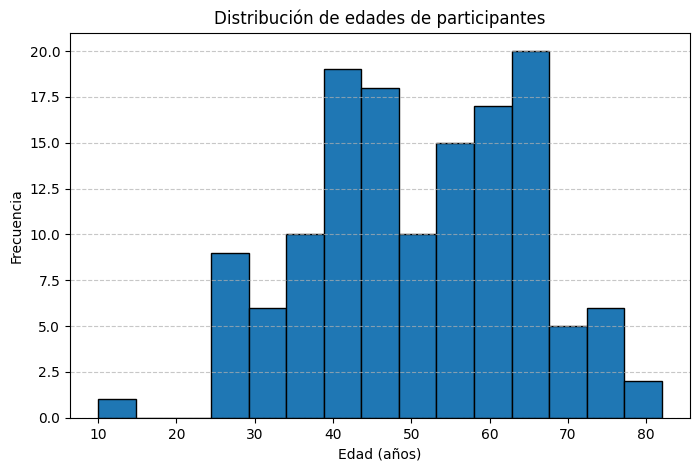

In [49]:
import matplotlib.pyplot as plt

col = "¿Cuantos años tienes?"

if col in df.columns:
    # Convertimos a numérico (algunos pueden venir como texto)
    df[col] = pd.to_numeric(df[col], errors="coerce")

    # Eliminamos valores nulos o fuera de rango razonable (por ejemplo <10 o >100)
    df_filtrado = df[(df[col] >= 10) & (df[col] <= 100)]

    plt.figure(figsize=(8,5))
    plt.hist(df_filtrado[col], bins=15, edgecolor="black")
    plt.title("Distribución de edades de participantes")
    plt.xlabel("Edad (años)")
    plt.ylabel("Frecuencia")
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()
else:
    print(f"⚠️ La columna '{col}' no existe en el DataFrame.")


## Genero

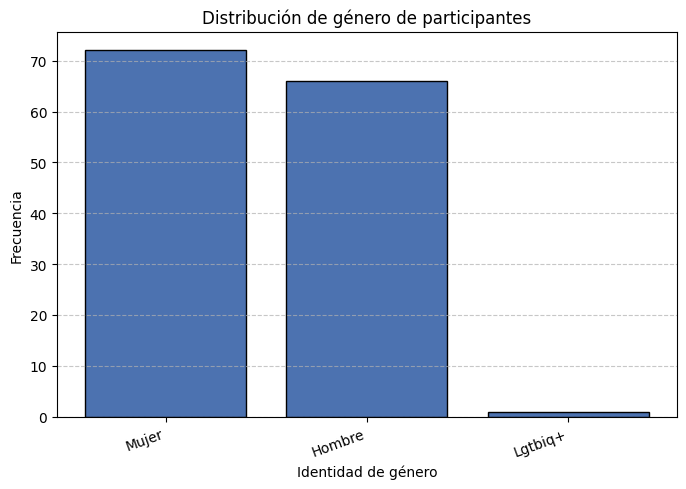

In [50]:

col_genero = "¿Cómo te identificas?"

if col_genero in df.columns:
    # Limpieza básica
    df[col_genero] = (
        df[col_genero]
        .astype(str)
        .str.strip()
        .str.title()
    )

    # Conteo de respuestas
    conteo = df[col_genero].value_counts(dropna=False)

    # Gráfico
    plt.figure(figsize=(8,5))
    plt.bar(conteo.index, conteo.values, color="#4C72B0", edgecolor="black")
    plt.title("Distribución de género de participantes")
    plt.xlabel("Identidad de género")
    plt.ylabel("Frecuencia")
    plt.xticks(rotation=20, ha="right")
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()
else:
    print(f"⚠️ La columna '{col_genero}' no existe en el DataFrame.")


## Cruce edad/genero    

C:\Users\Asus\AppData\Local\Temp\ipykernel_23764\1712766516.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtrado[col_genero] = (


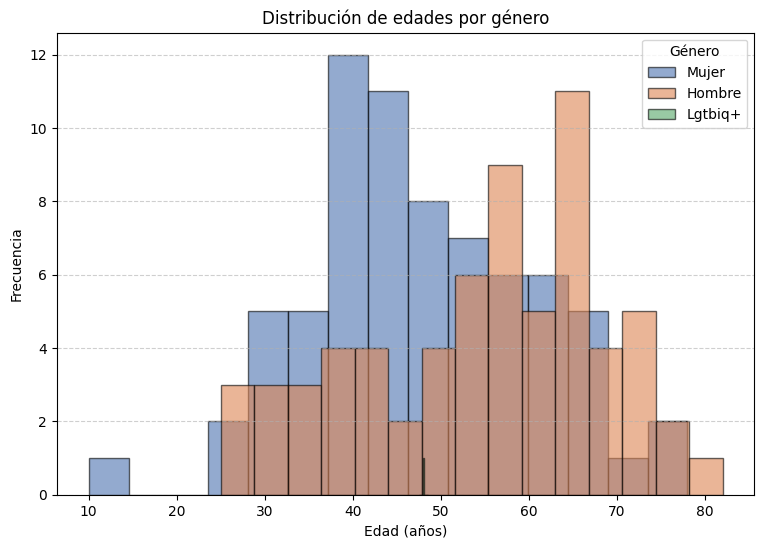

In [51]:
col_edad = "¿Cuantos años tienes?"
col_genero = "¿Cómo te identificas?"

if col_edad in df.columns and col_genero in df.columns:
    # Convertir edades a numérico y limpiar
    df[col_edad] = pd.to_numeric(df[col_edad], errors="coerce")
    df_filtrado = df[(df[col_edad] >= 10) & (df[col_edad] <= 100)]

    # Normalizar columna de género
    df_filtrado[col_genero] = (
        df_filtrado[col_genero]
        .astype(str)
        .str.strip()
        .str.title()
    )

    # Géneros únicos
    generos = df_filtrado[col_genero].unique()

    plt.figure(figsize=(9,6))

    # Colores básicos (puedes cambiarlos si prefieres)
    colores = ["#4C72B0", "#DD8452", "#55A868", "#C44E52"]

    for i, g in enumerate(generos):
        subset = df_filtrado[df_filtrado[col_genero] == g]
        plt.hist(subset[col_edad], bins=15, alpha=0.6, label=g,
                 color=colores[i % len(colores)], edgecolor="black")

    plt.title("Distribución de edades por género")
    plt.xlabel("Edad (años)")
    plt.ylabel("Frecuencia")
    plt.legend(title="Género")
    plt.grid(axis="y", linestyle="--", alpha=0.6)
    plt.show()

else:
    print("⚠️ No se encuentran una o ambas columnas requeridas.")


## Grupos especiales

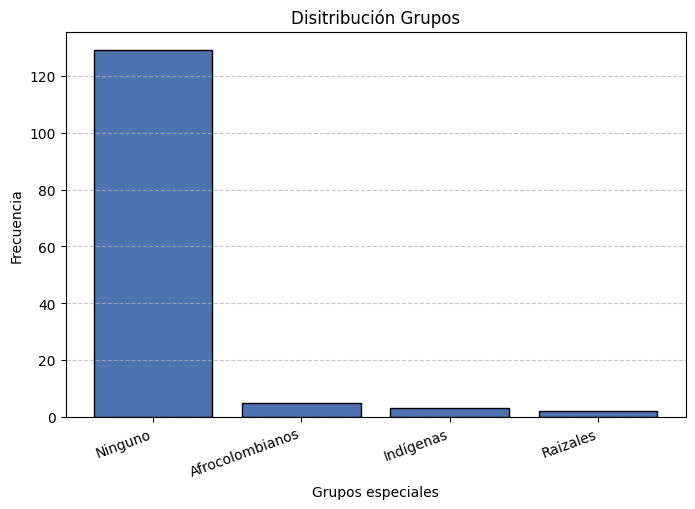

In [52]:

col_especiales = "¿Perteneces alguno de estos grupos?"

if col_especiales in df.columns:
    # Limpieza básica
    df[col_especiales] = (
        df[col_especiales]
        .astype(str)
        .str.strip()
        .str.title()
    )

    # Conteo de respuestas
    conteo = df[col_especiales].value_counts(dropna=False)

    # Gráfico
    plt.figure(figsize=(8,5))
    plt.bar(conteo.index, conteo.values, color="#4C72B0", edgecolor="black")
    plt.title("Disitribución Grupos")
    plt.xlabel("Grupos especiales")
    plt.ylabel("Frecuencia")
    plt.xticks(rotation=20, ha="right")
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()
else:
    print(f"⚠️ La columna '{col_especiales}' no existe en el DataFrame.")



## Método de contacto

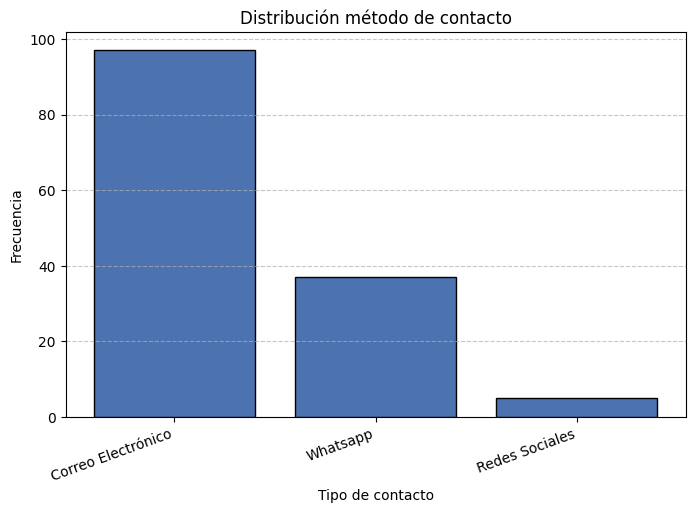

In [53]:
col_contacto = "¿Cómo te gustaría recibir información sobre la Expedición de las Justicias?"

if col_contacto in df.columns:
    # Limpieza básica
    df[col_contacto] = (
        df[col_contacto]
        .astype(str)
        .str.strip()
        .str.title()
    )

    # Conteo de respuestas
    conteo = df[col_contacto].value_counts(dropna=False)

    # Gráfico
    plt.figure(figsize=(8,5))
    plt.bar(conteo.index, conteo.values, color="#4C72B0", edgecolor="black")
    plt.title("Distribución método de contacto")
    plt.xlabel("Tipo de contacto")
    plt.ylabel("Frecuencia")
    plt.xticks(rotation=20, ha="right")
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()
else:
    print(f"⚠️ La columna '{col_contacto}' no existe en el DataFrame.")

## Área desarrollo actividades

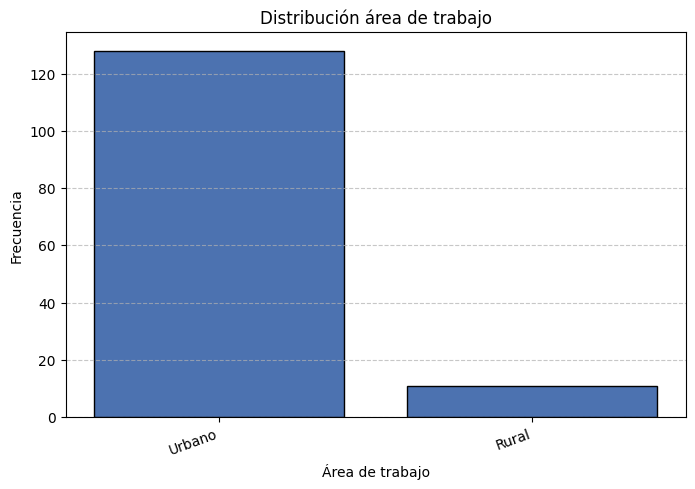

In [54]:
col_area = "¿En que área desarrollas mayoritariamente tu labor?"

if col_area in df.columns:
    # Limpieza básica
    df[col_area] = (
        df[col_area]
        .astype(str)
        .str.strip()
        .str.title()
    )

    # Conteo de respuestas
    conteo = df[col_area].value_counts(dropna=False)

    # Gráfico
    plt.figure(figsize=(8,5))
    plt.bar(conteo.index, conteo.values, color="#4C72B0", edgecolor="black")
    plt.title("Distribución área de trabajo")
    plt.xlabel("Área de trabajo")
    plt.ylabel("Frecuencia")
    plt.xticks(rotation=20, ha="right")
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()
else:
    print(f"⚠️ La columna '{col_contacto}' no existe en el DataFrame.")

## Tiempo de trabajo

In [55]:
from datetime import datetime

col = "¿Desde hace cuanto vienes ejerciendo esta labor?"

if col in df.columns:
    def extraer_anios(valor):
        if pd.isna(valor):
            return None

        texto = str(valor).strip().lower()
        texto = re.sub(r"\s+", " ", texto)

        # 1️⃣ Si es un año calendario (ej. 2015, 2021, 2023)
        m_anio = re.search(r"\b(19\d{2}|20\d{2})\b", texto)
        if m_anio:
            anio = int(m_anio.group(1))
            # Si parece ser una fecha pasada → calculamos antigüedad
            if 1990 <= anio <= datetime.now().year:
                return datetime.now().year - anio

        # 2️⃣ Si incluye meses (ej. "18 meses", "6 meses", "1 mes")
        m_meses = re.search(r"(\d+)\s*(mes|meses)", texto)
        if m_meses:
            meses = int(m_meses.group(1))
            return round(meses / 12, 1)  # convierte a años con un decimal

        # 3️⃣ Si incluye años explícitamente (ej. "8 años", "10 años aproximadamente")
        m_anios = re.search(r"(\d+)\s*(año|anos|años|anios)", texto)
        if m_anios:
            return int(m_anios.group(1))

        # 4️⃣ Si es solo número aislado (ej. "14", "30")
        m_num = re.search(r"\b\d{1,2}\b", texto)
        if m_num:
            return int(m_num.group(0))

        # 5️⃣ Si menciona fechas tipo “febrero de 2018”, “marzo 2020”
        m_fecha = re.search(r"(19|20)\d{2}", texto)
        if m_fecha:
            anio = int(m_fecha.group(0))
            return datetime.now().year - anio

        return None

    # Aplicar la función
    df["AñosExperiencia"] = df[col].apply(extraer_anios)

    # Opcional: revisar resumen rápido
    print("✅ Columna 'AñosExperiencia' creada correctamente.")
    print(df["AñosExperiencia"].describe())
else:
    print(f"⚠️ La columna '{col}' no existe en el DataFrame.")


✅ Columna 'AñosExperiencia' creada correctamente.
count    132.000000
mean      10.423485
std        8.692436
min        0.100000
25%        3.000000
50%        7.500000
75%       17.000000
max       48.000000
Name: AñosExperiencia, dtype: float64


In [56]:
print(df["AñosExperiencia"].value_counts())

AñosExperiencia
3.0     15
20.0    12
4.0     11
2.0     11
10.0     9
5.0      9
6.0      6
7.0      5
25.0     5
15.0     5
8.0      4
17.0     4
14.0     3
1.0      3
24.0     3
9.0      3
11.0     2
16.0     2
12.0     2
18.0     2
23.0     2
30.0     2
13.0     2
0.8      2
1.5      1
48.0     1
0.5      1
0.2      1
34.0     1
21.0     1
22.0     1
0.1      1
Name: count, dtype: int64


C:\Users\Asus\AppData\Local\Temp\ipykernel_23764\1459644802.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtrado["RangoExperiencia"] = pd.cut(


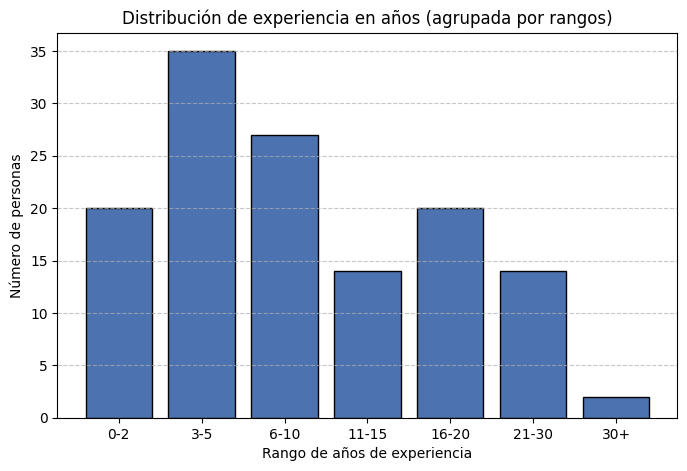

RangoExperiencia
0-2      20
3-5      35
6-10     27
11-15    14
16-20    20
21-30    14
30+       2
Name: count, dtype: int64


In [57]:
import numpy as np

col = "AñosExperiencia"

if col in df.columns:
    # Filtramos valores válidos (no nulos y dentro de un rango razonable)
    df_filtrado = df[(df[col].notna()) & (df[col] >= 0) & (df[col] <= 60)]

    # Definimos los intervalos (bins)
    bins = [0, 2, 5, 10, 15, 20, 30, 60]
    etiquetas = ["0-2", "3-5", "6-10", "11-15", "16-20", "21-30", "30+"]

    # Creamos una nueva columna con la categoría correspondiente
    df_filtrado["RangoExperiencia"] = pd.cut(
        df_filtrado[col],
        bins=bins,
        labels=etiquetas,
        include_lowest=True,
        right=True
    )

    # Conteo de cada rango
    conteo = df_filtrado["RangoExperiencia"].value_counts().sort_index()

    # Gráfico de barras
    plt.figure(figsize=(8,5))
    plt.bar(conteo.index, conteo.values, color="#4C72B0", edgecolor="black")
    plt.title("Distribución de experiencia en años (agrupada por rangos)")
    plt.xlabel("Rango de años de experiencia")
    plt.ylabel("Número de personas")
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()

    print(conteo)
else:
    print(f"⚠️ La columna '{col}' no existe en el DataFrame.")


## Tipos de Problemas       

In [58]:

col_conflictos = "¿Qué tipos de conflictos o problemas atiendes principalmente?"

# --- Funciones auxiliares ---
def quitar_acentos(texto):
    return "".join(
        c for c in unicodedata.normalize("NFD", str(texto))
        if unicodedata.category(c) != "Mn"
    )

def limpiar_texto(texto):
    if pd.isna(texto):
        return ""
    t = str(texto).lower()
    t = quitar_acentos(t)
    t = re.sub(r"[^a-zñáéíóúü\s,;:/-]", " ", t)
    t = re.sub(r"\s+", " ", t)
    return t.strip()

# --- Stopwords básicas (ajustadas al contexto colombiano) ---
stopwords = set([
    "de", "del", "la", "las", "los", "y", "en", "el", "a", "para", "por", 
    "con", "entre", "sobre", "un", "una", "como", "etc", "otros", "otras", 
    "principalmente", "problemas", "conflictos", "casos"
])

def eliminar_stopwords(texto):
    palabras = texto.split()
    return " ".join([p for p in palabras if p not in stopwords])

# --- Limpieza total del texto ---
df["Conflictos_limpio"] = (
    df[col_conflictos]
    .fillna("")
    .apply(limpiar_texto)
    .apply(eliminar_stopwords)
)

# --- Diccionario de categorías y palabras clave ---
diccionario_conflictos = {
    "Familiares": [
        "familia", "familiar", "convivencia", "violencia", "intrafamiliar",
        "genero", "niños", "mujeres", "adultos mayores", "hogar"
    ],
    "Comunitarios": [
        "comunidad", "comunitario", "vecinos", "barrio", "consejo", "participacion", "convivencia"
    ],
    "Civiles": [
        "civil", "civiles", "restitucion", "pertenencia", "arrendamiento", "contrato", 
        "ejecutivo", "propiedad", "posesion", "inquilino", "inquilinos"
    ],
    "Laborales": [
        "laboral", "laborales", "trabajo", "empleo", "seguridad social", "sindicato"
    ],
    "Penales": [
        "penal", "delito", "contravencion", "violacion", "abuso", "carcel", "prision"
    ],
    "Económicos": [
        "economico", "deuda", "dinero", "incumplimiento", "prestamo", "credito"
    ],
    "De tierras": [
        "tierra", "tierras", "rural", "predio", "predios", "despojo", "restitucion"
    ],
    "Otros": [
        "constitucional", "ambiental", "educativo", "salud", "justicia"
    ]
}

# --- Asignación de categorías (matriz binaria) ---
for categoria, palabras in diccionario_conflictos.items():
    patron = r"\b(" + "|".join(palabras) + r")\b"
    df[categoria] = df["Conflictos_limpio"].apply(lambda x: 1 if re.search(patron, x) else 0)

# --- Verificación de resultados ---
categorias = list(diccionario_conflictos.keys())
df_conflictos = df[["Conflictos_limpio"] + categorias]

print("✅ Matriz de conflictos creada correctamente.")
print(df_conflictos[categorias].sum().sort_values(ascending=False))


✅ Matriz de conflictos creada correctamente.
Familiares      67
Comunitarios    39
Civiles         21
De tierras       5
Económicos       3
Penales          3
Laborales        2
Otros            2
dtype: int64


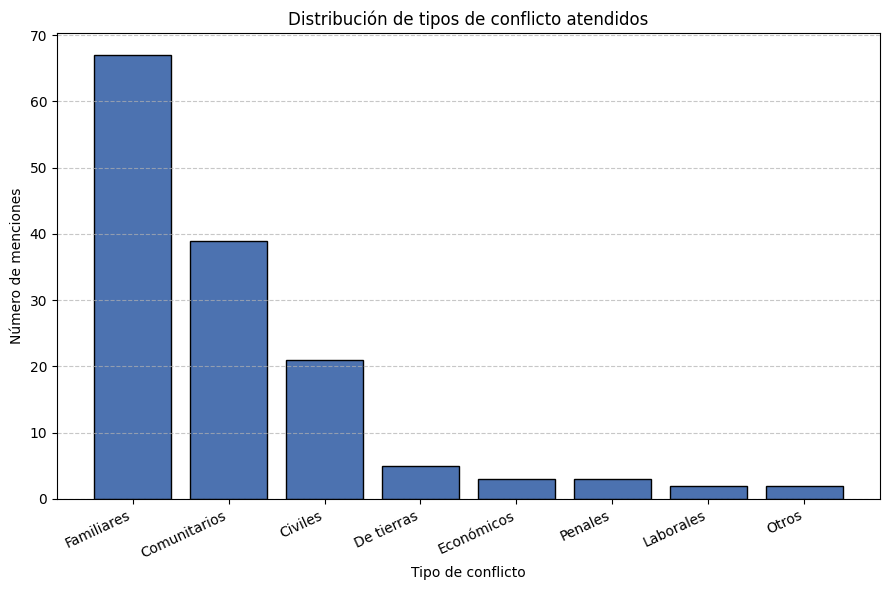

📊 Conteo total por tipo de conflicto:
Familiares      67
Comunitarios    39
Civiles         21
De tierras       5
Económicos       3
Penales          3
Laborales        2
Otros            2
dtype: int64


In [59]:
# --- Seleccionamos solo las columnas de categorías ---
categorias = [
    "Familiares", "Comunitarios", "Civiles", "Laborales",
    "Penales", "Económicos", "De tierras", "Otros"
]

# --- Conteo total por tipo de conflicto ---
conteo = df[categorias].sum().sort_values(ascending=False)

# --- Gráfico de barras ---
plt.figure(figsize=(9,6))
plt.bar(conteo.index, conteo.values, color="#4C72B0", edgecolor="black")
plt.title("Distribución de tipos de conflicto atendidos")
plt.xlabel("Tipo de conflicto")
plt.ylabel("Número de menciones")
plt.xticks(rotation=25, ha="right")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

# (opcional) Mostrar tabla resumen
print("📊 Conteo total por tipo de conflicto:")
print(conteo)


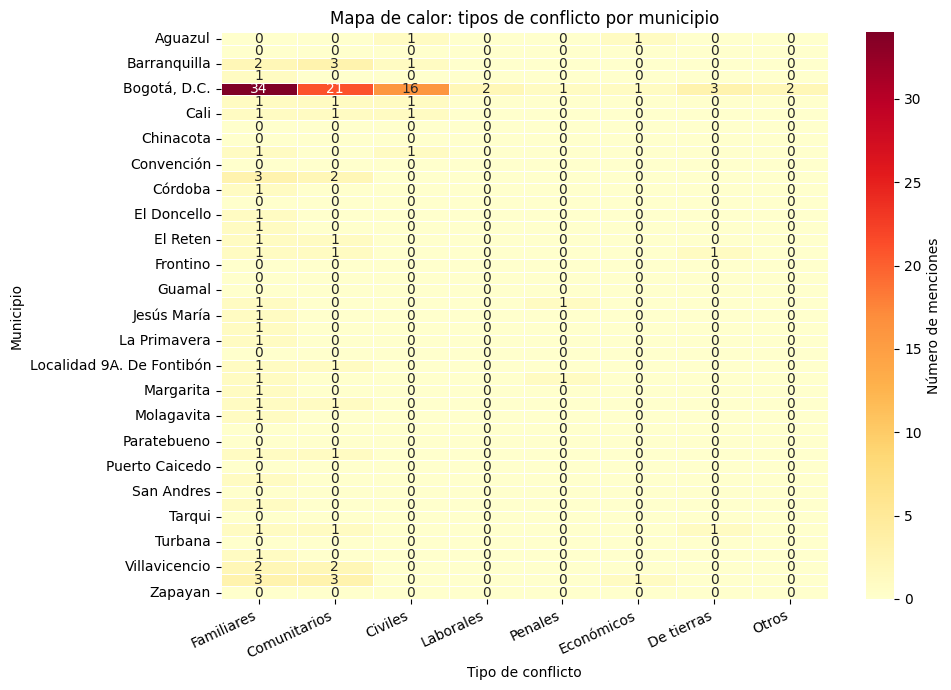

✅ Mapa de calor generado correctamente.


In [60]:
import seaborn as sns


# --- Variables base ---
col_municipio = "Municipio donde trabajas"
categorias = [
    "Familiares", "Comunitarios", "Civiles", "Laborales",
    "Penales", "Económicos", "De tierras", "Otros"
]

# --- Verificamos que las columnas existan ---
if col_municipio in df.columns and all(c in df.columns for c in categorias):
    # Agrupamos: sumamos los 1s por municipio y tipo de conflicto
    tabla_calor = (
        df.groupby(col_municipio)[categorias]
        .sum()
        .sort_index()
    )

    # --- Mapa de calor ---
    plt.figure(figsize=(10,7))
    sns.heatmap(
        tabla_calor,
        cmap="YlOrRd",
        linewidths=0.5,
        linecolor="white",
        annot=True,
        fmt=".0f",
        cbar_kws={'label': 'Número de menciones'}
    )

    plt.title("Mapa de calor: tipos de conflicto por municipio")
    plt.xlabel("Tipo de conflicto")
    plt.ylabel("Municipio")
    plt.xticks(rotation=25, ha="right")
    plt.tight_layout()
    plt.show()

    print("✅ Mapa de calor generado correctamente.")
else:
    print("⚠️ Revisa que existan las columnas 'Municipio donde trabajas' y las categorías de conflicto.")


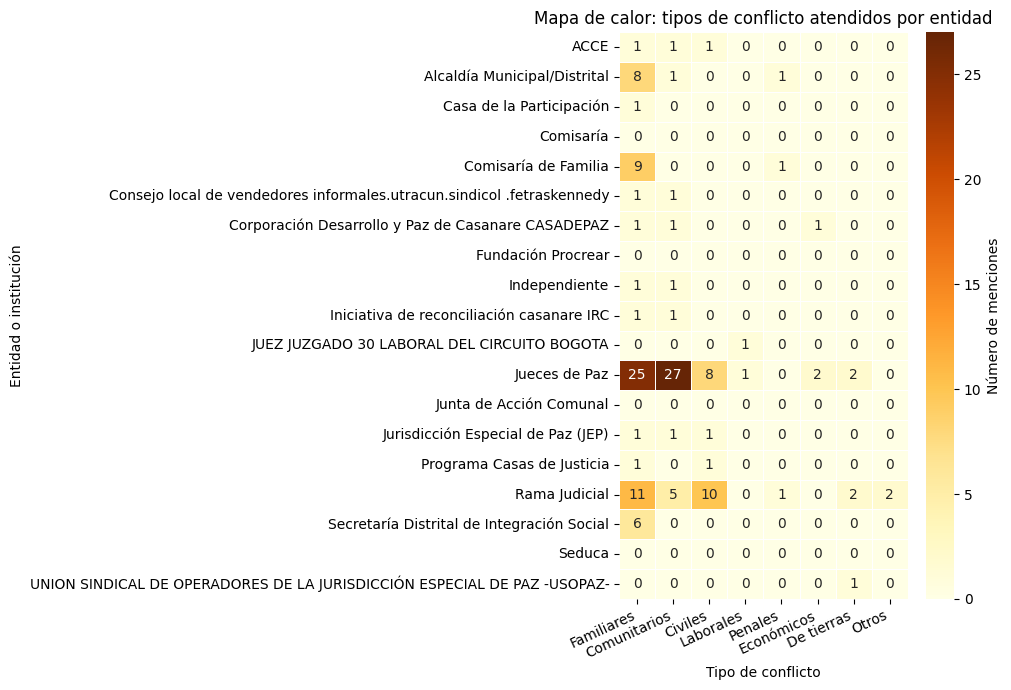

✅ Mapa de calor generado correctamente.


In [61]:
# --- Variables base ---
col_entidad = "Entidad (normalizada)"
categorias = [
    "Familiares", "Comunitarios", "Civiles", "Laborales",
    "Penales", "Económicos", "De tierras", "Otros"
]

# --- Validación de columnas ---
if col_entidad in df.columns and all(c in df.columns for c in categorias):
    # Agrupamos: sumamos los 1s por entidad
    tabla_entidad = (
        df.groupby(col_entidad)[categorias]
        .sum()
        .sort_index()
    )

    # --- Mapa de calor ---
    plt.figure(figsize=(10,7))
    sns.heatmap(
        tabla_entidad,
        cmap="YlOrBr",
        linewidths=0.5,
        linecolor="white",
        annot=True,
        fmt=".0f",
        cbar_kws={'label': 'Número de menciones'}
    )

    plt.title("Mapa de calor: tipos de conflicto atendidos por entidad")
    plt.xlabel("Tipo de conflicto")
    plt.ylabel("Entidad o institución")
    plt.xticks(rotation=25, ha="right")
    plt.tight_layout()
    plt.show()

    print("✅ Mapa de calor generado correctamente.")
else:
    print("⚠️ Revisa que existan las columnas 'Entidad (normalizada)' y las categorías de conflicto.")


In [62]:
import folium

# === 1) Prepara tus datos agregados por municipio ===
col_mpio = "Municipio donde trabajas"
categoria = "Familiares"   # cambia por "Comunitarios", "Civiles", etc.

df_mapa = (
    df.groupby(col_mpio)[categoria]
      .sum()
      .reset_index()
      .rename(columns={col_mpio:"municipio", categoria:"valor"})
)

def norm_txt(s):
    s = str(s).strip().lower()
    s = "".join(c for c in unicodedata.normalize("NFD", s) if unicodedata.category(c) != "Mn")
    s = re.sub(r"[.,]", "", s)
    s = re.sub(r"\s+", " ", s)
    return s

df_mapa["muni_norm"] = df_mapa["municipio"].apply(norm_txt)

# === 2) Usa un GeoJSON de municipios ===
# Opción A) GitHub (MGN 2018). Si lo bajas, pon la ruta local; si lo lees remoto, usa la URL RAW.
geojson_url = "https://raw.githubusercontent.com/caticoa3/colombia_mapa/master/co_2018_MGN_MPIO_POLITICO.geojson"  # ← ruta directa

import json, requests
g = requests.get(geojson_url).json()

# Detecta el nombre del campo de municipio en el GeoJSON (suele ser "MPIO_CNMBR" o "NOMBRE")
# Aquí intento con "MPIO_CNMBR"; si no te pinta, imprime g['features'][0]['properties'] y ajusta:
geo_field_name = "MPIO_CNMBR"

# Crea un campo normalizado en el GeoJSON para hacer el join por nombre
for ft in g["features"]:
    raw_name = ft["properties"].get(geo_field_name, "")
    ft["properties"]["muni_norm"] = norm_txt(raw_name)

# === 3) Join y construcción del mapa ===
# Folium choropleth espera que el DataFrame tenga la llave y el valor
m = folium.Map(location=[4.6, -74.1], zoom_start=5, tiles="CartoDB positron")

folium.Choropleth(
    geo_data=g,
    data=df_mapa,
    columns=["muni_norm", "valor"],
    key_on="feature.properties.muni_norm",
    fill_color="YlOrRd",
    fill_opacity=0.85,
    line_opacity=0.3,
    nan_fill_color="lightgray",
    legend_name=f"Conflictos {categoria.lower()} (conteo)"
).add_to(m)

# Tooltip con el nombre real del municipio y el valor
folium.GeoJson(
    g,
    name="labels",
    style_function=lambda x: {"color":"transparent","fillOpacity":0},
    tooltip=folium.features.GeoJsonTooltip(
        fields=[geo_field_name],
        aliases=["Municipio:"],
        labels=True,
        sticky=True
    )
).add_to(m)

m


## Conteo Problemas

In [63]:
#verificamos primero el grado de dispersión

print(df["¿Cuantos problemas o conflictos atiendes por mes?"].describe())

count    139.000000
mean      81.167986
std      136.480144
min        1.000000
25%       10.000000
50%       25.000000
75%       65.000000
max      850.000000
Name: ¿Cuantos problemas o conflictos atiendes por mes?, dtype: float64


#### encontramos algo extraño, y es las altisima dispersión del número de casos atentidos, donde podemos asumir que hay personas que sobreestimaron su capacidad de gestión y solución de conflictos

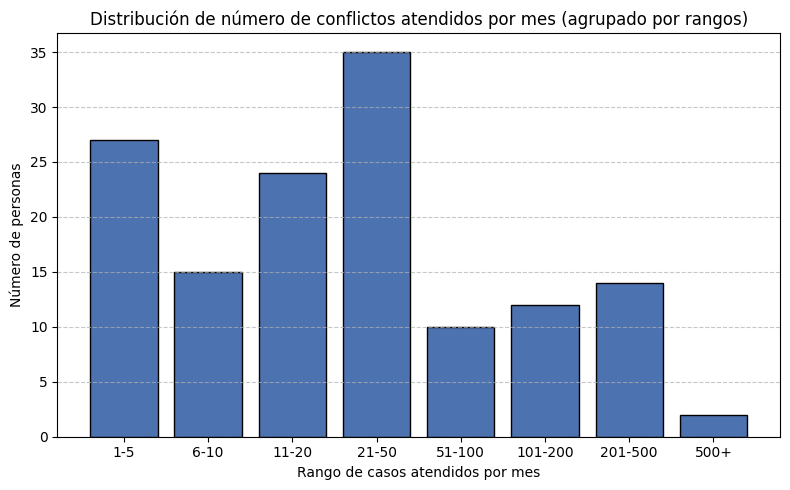

📊 Conteo por rango de atención mensual:
RangoCasosMes
1-5        27
6-10       15
11-20      24
21-50      35
51-100     10
101-200    12
201-500    14
500+        2
Name: count, dtype: int64


In [64]:
col = "¿Cuantos problemas o conflictos atiendes por mes?"

if col in df.columns:
    # Aseguramos tipo numérico
    df[col] = pd.to_numeric(df[col], errors="coerce")

    # Filtramos valores razonables (evitar outliers extremos)
    df_filtrado = df[(df[col] > 0) & (df[col] <= 1000)]

    # Definimos los bins (puedes ajustarlos según dispersión)
    bins = [0, 5, 10, 20, 50, 100, 200, 500, 1000]
    etiquetas = ["1-5", "6-10", "11-20", "21-50", "51-100", "101-200", "201-500", "500+"]

    # Creamos columna de rangos
    df_filtrado["RangoCasosMes"] = pd.cut(
        df_filtrado[col],
        bins=bins,
        labels=etiquetas,
        include_lowest=True,
        right=True
    )

    # Conteo por rango
    conteo = df_filtrado["RangoCasosMes"].value_counts().sort_index()

    # --- Histograma por bins ---
    plt.figure(figsize=(8,5))
    plt.bar(conteo.index, conteo.values, color="#4C72B0", edgecolor="black")
    plt.title("Distribución de número de conflictos atendidos por mes (agrupado por rangos)")
    plt.xlabel("Rango de casos atendidos por mes")
    plt.ylabel("Número de personas")
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.show()

    print("📊 Conteo por rango de atención mensual:")
    print(conteo)
else:
    print(f"⚠️ La columna '{col}' no existe en el DataFrame.")


### algo interesante que podemos identificar, es como se comportan el número de problemas vs los operadores. 

C:\Users\Asus\AppData\Local\Temp\ipykernel_23764\3466265020.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby([col_entidad,"RangoCasosMes"])


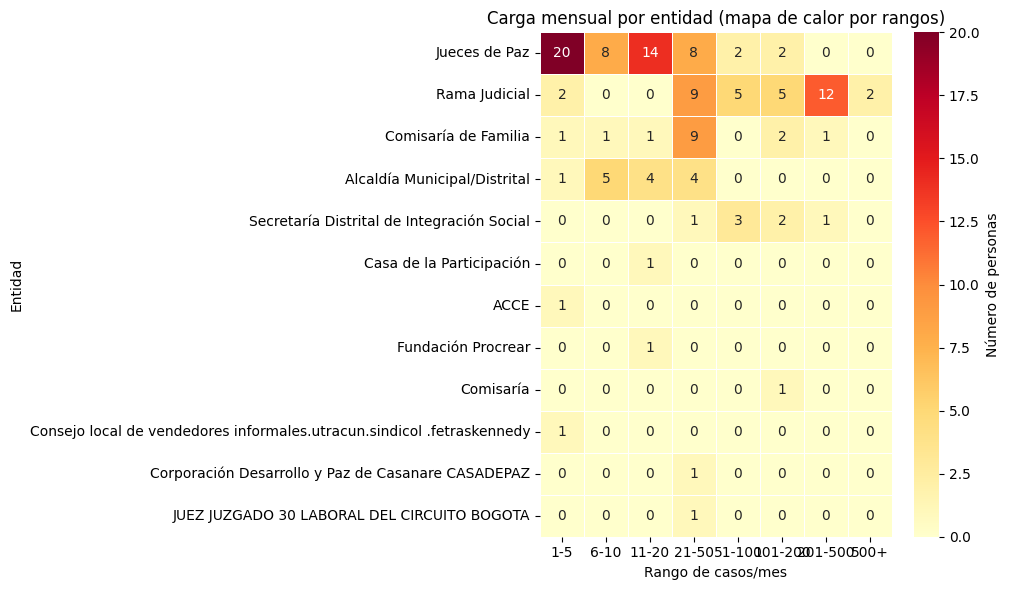

In [67]:
col_casos = "¿Cuantos problemas o conflictos atiendes por mes?"
col_entidad = "Entidad (normalizada)"

df[col_casos] = pd.to_numeric(df[col_casos], errors="coerce")
df_f = df[(df[col_casos] > 0) & (df[col_casos] <= 1000)].copy()

bins = [0,5,10,20,50,100,200,500,1000]
labs = ["1-5","6-10","11-20","21-50","51-100","101-200","201-500","500+"]

df_f["RangoCasosMes"] = pd.cut(df_f[col_casos], bins=bins, labels=labs, include_lowest=True, right=True)

tabla = (df_f
         .groupby([col_entidad,"RangoCasosMes"])
         .size().unstack(fill_value=0))

# Ordena entidades por total descendente y deja top-12 (el resto se puede agrupar si quieres)
tabla = tabla.loc[tabla.sum(1).sort_values(ascending=False).index].head(12)

plt.figure(figsize=(10,6))
sns.heatmap(tabla, cmap="YlOrRd", linewidths=.5, linecolor="white", annot=True, fmt=".0f",
            cbar_kws={'label':'Número de personas'})
plt.title("Carga mensual por entidad (mapa de calor por rangos)")
plt.xlabel("Rango de casos/mes")
plt.ylabel("Entidad")
plt.tight_layout()
plt.show()


C:\Users\Asus\AppData\Local\Temp\ipykernel_23764\68738714.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  conteo = (tmp.groupby([col_entidad,"RangoCasosMes"])


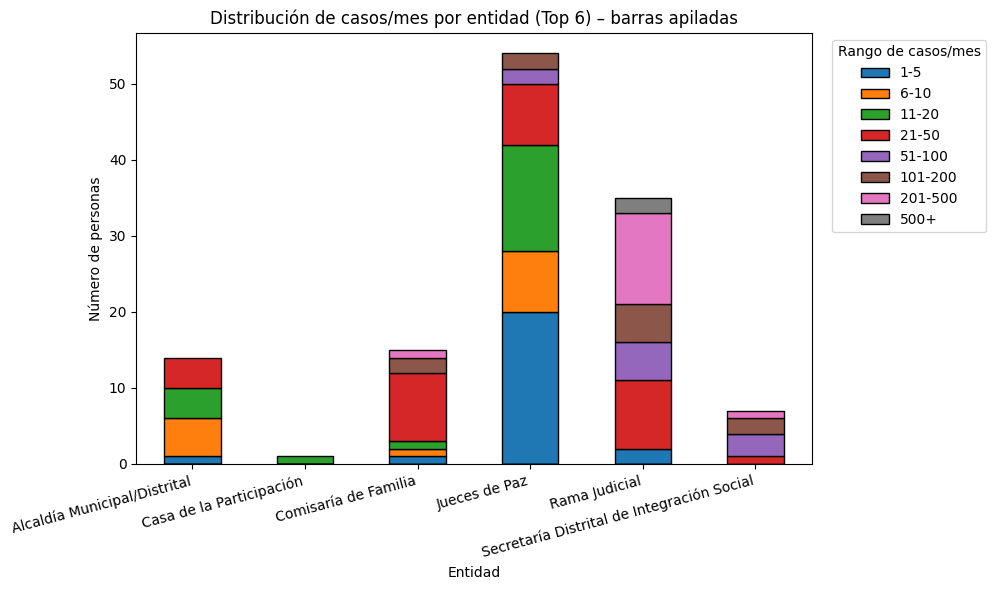

In [68]:

topN = 6
df_top = (df_f.groupby(col_entidad)[col_casos].size()
          .sort_values(ascending=False).head(topN).index)
tmp = df_f[df_f[col_entidad].isin(df_top)]

conteo = (tmp.groupby([col_entidad,"RangoCasosMes"])
          .size().unstack(fill_value=0))[labs]  # asegura orden de bins

ax = conteo.plot(kind="bar", stacked=True, figsize=(10,6), edgecolor="black")
plt.title("Distribución de casos/mes por entidad (Top 6) – barras apiladas")
plt.xlabel("Entidad")
plt.ylabel("Número de personas")
plt.xticks(rotation=15, ha="right")
plt.legend(title="Rango de casos/mes", bbox_to_anchor=(1.02,1), loc="upper left")
plt.tight_layout()
plt.show()


# Meses de solución

In [69]:
#verificamos nuevamente, posibilidad de muchos outliers
print(df["En número de meses y de acuerdo a tu experiencia ¿cuanto tiempo consideras se llega a una solución a un problema o conflicto?"].describe())

count    139.000000
mean      13.733813
std       34.981066
min        1.000000
25%        2.000000
50%        3.000000
75%       13.500000
max      355.000000
Name: En número de meses y de acuerdo a tu experiencia ¿cuanto tiempo consideras se llega a una solución a un problema o conflicto?, dtype: float64


### es evidente, por sobretodo la diferencia en el número de meses, que hay entidades y/o organizaciones que pueden gestionar más rapido algunos problemas, por lo que es importante tener en cuenta este elemento para poder realizar comparaciones realistas. 

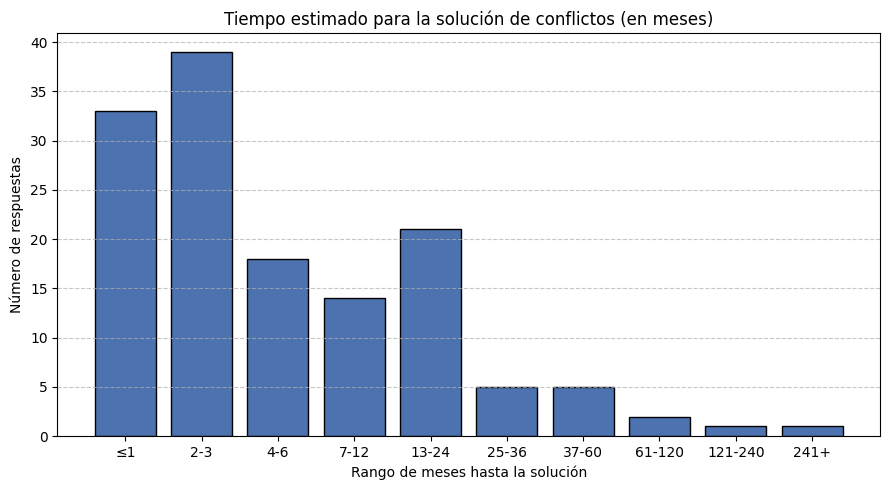

📊 Conteo por rango de tiempo estimado para la solución:
RangoMesesSolucion
≤1         33
2-3        39
4-6        18
7-12       14
13-24      21
25-36       5
37-60       5
61-120      2
121-240     1
241+        1
Name: count, dtype: int64


In [70]:

col = "En número de meses y de acuerdo a tu experiencia ¿cuanto tiempo consideras se llega a una solución a un problema o conflicto?"

if col in df.columns:
    # Aseguramos tipo numérico
    df[col] = pd.to_numeric(df[col], errors="coerce")

    # Filtramos valores válidos (hasta 400 meses = ~33 años)
    df_filtrado = df[(df[col] > 0) & (df[col] <= 400)]

    # Definimos los bins (más densos en los primeros meses)
    bins = [0, 1, 3, 6, 12, 24, 36, 60, 120, 240, 400]
    etiquetas = [
        "≤1", "2-3", "4-6", "7-12", "13-24", "25-36",
        "37-60", "61-120", "121-240", "241+"
    ]

    # Creamos columna de rangos
    df_filtrado["RangoMesesSolucion"] = pd.cut(
        df_filtrado[col],
        bins=bins,
        labels=etiquetas,
        include_lowest=True,
        right=True
    )

    # Conteo por rango
    conteo = df_filtrado["RangoMesesSolucion"].value_counts().sort_index()

    # --- Histograma ---
    plt.figure(figsize=(9,5))
    plt.bar(conteo.index, conteo.values, color="#4C72B0", edgecolor="black")
    plt.title("Tiempo estimado para la solución de conflictos (en meses)")
    plt.xlabel("Rango de meses hasta la solución")
    plt.ylabel("Número de respuestas")
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.show()

    print("📊 Conteo por rango de tiempo estimado para la solución:")
    print(conteo)
else:
    print(f"⚠️ La columna '{col}' no existe en el DataFrame.")


### algo que puede ser de mucha utilidad es revisar como es el comportamiento del tiempo de solución vs los problemas, para conocer que tipos de problemas tiende a solucionar

In [72]:
df.head()

,ID,Hora de inicio,Nombre completo,Entidad o institución a la que perteneces,Departamento donde laboras:,Municipio donde trabajas,Dirección donde trabajas,"En caso de trabajar en Bogotá, ¿podrías indicar la localidad desde la cual trabajas?",¿Cuantos años tienes?,¿Cómo te identificas?,...,AñosExperiencia,Conflictos_limpio,Familiares,Comunitarios,Civiles,Laborales,Penales,Económicos,De tierras,Otros
0,1,2025-10-24 09:16:37,Sandra Liliana Cruz Martinez,Secretaria de integracion social,DISTRITO CAPITAL,"Bogotá, D.C.",Carrera 2 N.4-10,La Candelaria,53,Mujer,...,18.0,"violencia intrafamiliar, familiares, maltrato ...",1,0,0,0,0,0,0,0
1,2,2025-10-24 09:20:19,José William Cardenas Aldana,JURISDICCIÓN DE PAZ,DISTRITO CAPITAL,"Bogotá, D.C.",CARRERA 10 # 14 - 33 EDIFICIO HERNANDO MORALES,Rafael Uribe,63,Hombre,...,18.0,"arrendamiento, deudas, familiares",0,0,1,0,0,0,0,0
2,3,2025-10-24 09:21:02,Camilo Andrés Rodríguez Toro,Comisaría de Familia de Barrios Unidos,DISTRITO CAPITAL,"Bogotá, D.C.",Calle 68 número 53-34,Barrios Unidos,42,Hombre,...,7.0,violencia contexto familiar,1,0,0,0,0,0,0,0
3,4,2025-10-24 09:37:14,Luis Enrique Zambrano Rojas,JUNTA DE ACCION COMUNAL COSTA RICA SUBA,DISTRITO CAPITAL,"Bogotá, D.C.",CALLE 130 C # 93 17,Suba,65,Hombre,...,8.0,comunitarios,0,0,0,0,0,0,0,0
4,5,2025-10-24 10:07:40,Zaida Milena Badillo Sepúlveda,Jurisdicción de Paz,DISTRITO CAPITAL,"Bogotá, D.C.",Reserva,Engativá,48,Mujer,...,5.0,comunitarios arrendamientos,0,0,0,0,0,0,0,0


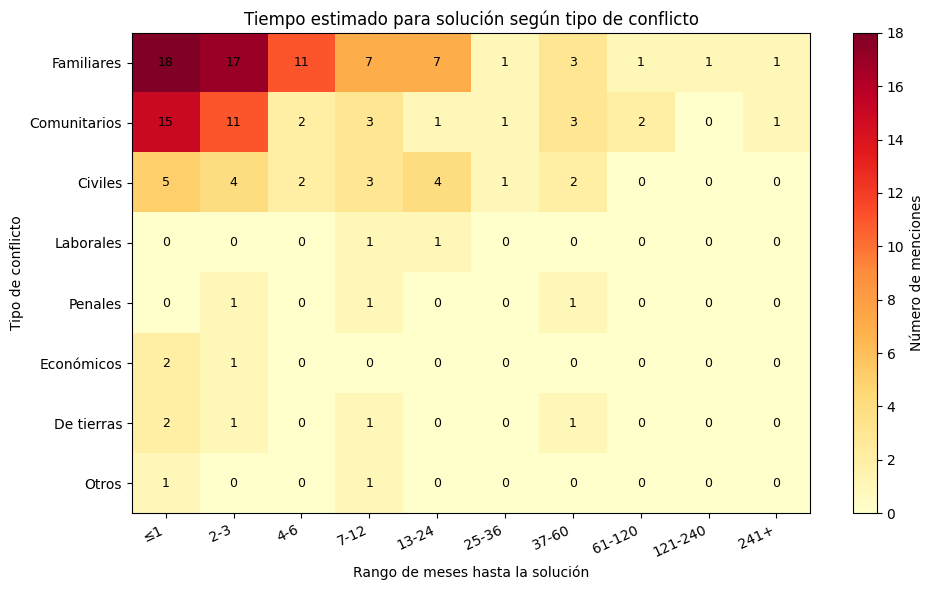

RangoMesesSolucion  ≤1  2-3  4-6  7-12  13-24  25-36  37-60  61-120  121-240  \
TipoConflicto                                                                  
Familiares          18   17   11     7      7      1      3       1        1   
Comunitarios        15   11    2     3      1      1      3       2        0   
Civiles              5    4    2     3      4      1      2       0        0   
Laborales            0    0    0     1      1      0      0       0        0   
Penales              0    1    0     1      0      0      1       0        0   
Económicos           2    1    0     0      0      0      0       0        0   
De tierras           2    1    0     1      0      0      1       0        0   
Otros                1    0    0     1      0      0      0       0        0   

RangoMesesSolucion  241+  
TipoConflicto             
Familiares             1  
Comunitarios           1  
Civiles                0  
Laborales              0  
Penales                0  
Económicos

In [73]:

# --- Columnas existentes en tu df ---
col_rangos = "RangoMesesSolucion"  # ya creada en el paso anterior (bins de meses)
# Detecta solo las categorías que realmente existen en tu df
posibles_categorias = ["Familiares","Comunitarios","Civiles","Laborales","Penales","Económicos","De tierras","Otros"]
categorias = [c for c in posibles_categorias if c in df.columns]

# 1) Aseguramos que la columna de rangos exista; si no, la creamos desde la columna numérica
if col_rangos not in df.columns:
    col_meses = "En número de meses y de acuerdo a tu experiencia ¿cuanto tiempo consideras se llega a una solución a un problema o conflicto?"
    df[col_meses] = pd.to_numeric(df.get(col_meses), errors="coerce")
    bins = [0, 1, 3, 6, 12, 24, 36, 60, 120, 240, 400]
    labels = ["≤1","2-3","4-6","7-12","13-24","25-36","37-60","61-120","121-240","241+"]
    df[col_rangos] = pd.cut(df[col_meses], bins=bins, labels=labels, include_lowest=True, right=True)
else:
    # Orden objetivo de columnas del mapa con las etiquetas reales presentes
    labels = list(df[col_rangos].cat.categories if hasattr(df[col_rangos], "cat") else df[col_rangos].dropna().unique())
    # Garantiza el orden estándar si coincide con nuestras etiquetas sugeridas
    orden_sugerido = ["≤1","2-3","4-6","7-12","13-24","25-36","37-60","61-120","121-240","241+"]
    labels = [l for l in orden_sugerido if l in labels] + [l for l in labels if l not in orden_sugerido]

# 2) Pasamos de matriz binaria a formato largo, filtrando nulos y tomando solo donde la categoría está marcada (1)
use_cols = [col_rangos] + categorias
tmp = df[use_cols].copy()
tmp = tmp[tmp[col_rangos].notna()]                        # solo filas con rango válido
tmp[categorias] = tmp[categorias].fillna(0).astype(int)   # asegura 0/1 enteros

df_long = tmp.melt(id_vars=[col_rangos],
                   value_vars=categorias,
                   var_name="TipoConflicto",
                   value_name="Presente")
df_long = df_long[df_long["Presente"] == 1]

# 3) Tabla (crosstab) ordenada por filas y columnas
tabla = pd.crosstab(df_long["TipoConflicto"], df_long[col_rangos]).reindex(index=categorias)
# reordenamos columnas según 'labels'
tabla = tabla.reindex(columns=labels).fillna(0).astype(int)

# 4) Mapa de calor con matplotlib (sin seaborn)
fig, ax = plt.subplots(figsize=(10, 6))
im = ax.imshow(tabla.values, aspect="auto", cmap="YlOrRd")

# Etiquetas ejes
ax.set_xticks(range(len(tabla.columns)))
ax.set_xticklabels(tabla.columns, rotation=25, ha="right")
ax.set_yticks(range(len(tabla.index)))
ax.set_yticklabels(tabla.index)

# Anotaciones en cada celda
for i in range(tabla.shape[0]):
    for j in range(tabla.shape[1]):
        val = tabla.iat[i, j]
        ax.text(j, i, str(val), ha="center", va="center", fontsize=9, color="black")

# Colorbar y títulos
cbar = fig.colorbar(im)
cbar.set_label("Número de menciones")
ax.set_title("Tiempo estimado para solución según tipo de conflicto")
ax.set_xlabel("Rango de meses hasta la solución")
ax.set_ylabel("Tipo de conflicto")
plt.tight_layout()
plt.show()

# (opcional) imprime la tabla resultante
print(tabla)


### como lo indicaba la intuición, los problemas de caracter familiares y comunitarios tienden a resolverse rapidamente, mientras que problemas de ordenes o con especialidades legales puntuales pueden demorarse un poco más. Ahora, sería muy interesante ver como es la distribución de los tiempos de solución por categoría de servicio de justicia

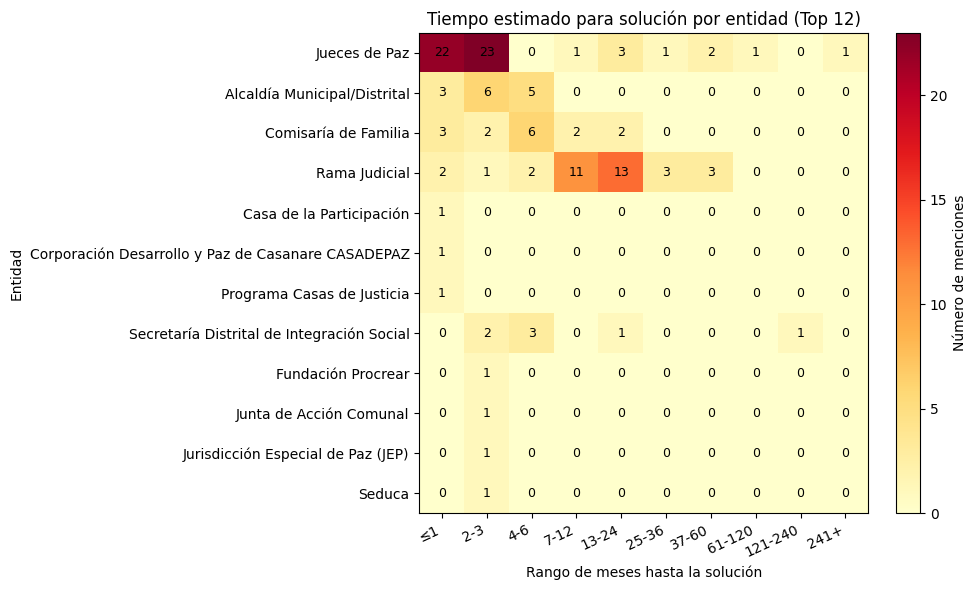

RangoMesesSolucion                                  ≤1  2-3  4-6  7-12  13-24  \
Entidad (normalizada)                                                           
Jueces de Paz                                       22   23    0     1      3   
Alcaldía Municipal/Distrital                         3    6    5     0      0   
Comisaría de Familia                                 3    2    6     2      2   
Rama Judicial                                        2    1    2    11     13   
Casa de la Participación                             1    0    0     0      0   
Corporación Desarrollo y Paz de Casanare CASADEPAZ   1    0    0     0      0   
Programa Casas de Justicia                           1    0    0     0      0   
Secretaría Distrital de Integración Social           0    2    3     0      1   
Fundación Procrear                                   0    1    0     0      0   
Junta de Acción Comunal                              0    1    0     0      0   
Jurisdicción Especial de Paz

In [75]:
col_entidad = "Entidad (normalizada)"
col_rangos = "RangoMesesSolucion"
col_meses = "En número de meses y de acuerdo a tu experiencia ¿cuanto tiempo consideras se llega a una solución a un problema o conflicto?"

# --- Aseguramos que la columna de meses y rangos esté bien formateada ---
df[col_meses] = pd.to_numeric(df.get(col_meses), errors="coerce")

# Si no existe la columna categórica, la creamos
if col_rangos not in df.columns:
    bins = [0, 1, 3, 6, 12, 24, 36, 60, 120, 240, 400]
    etiquetas = ["≤1","2-3","4-6","7-12","13-24","25-36","37-60","61-120","121-240","241+"]
    df[col_rangos] = pd.cut(df[col_meses], bins=bins, labels=etiquetas, include_lowest=True, right=True)

# --- Limpieza de datos ---
df[col_entidad] = df[col_entidad].astype(str).str.strip()
df = df[df[col_entidad].notna() & df[col_rangos].notna()]

# --- Creamos la tabla Entidad x Rango ---
tabla = pd.crosstab(df[col_entidad], df[col_rangos])

# Filtramos entidades con datos (evita todas NaN)
tabla = tabla.loc[tabla.sum(axis=1) > 0]

# Ordenamos filas (por total descendente) y columnas (por orden lógico)
orden_cols = ["≤1","2-3","4-6","7-12","13-24","25-36","37-60","61-120","121-240","241+"]
tabla = tabla.reindex(columns=[c for c in orden_cols if c in tabla.columns])

# Top N entidades
topN = 12
tabla_top = tabla.sort_values(by=tabla.columns.tolist(), ascending=False).head(topN)

# --- Gráfico ---
fig, ax = plt.subplots(figsize=(10,6))
im = ax.imshow(tabla_top.values, cmap="YlOrRd", aspect="auto")

# Ejes
ax.set_xticks(range(len(tabla_top.columns)))
ax.set_xticklabels(tabla_top.columns, rotation=25, ha="right")
ax.set_yticks(range(len(tabla_top.index)))
ax.set_yticklabels(tabla_top.index)

# Anotaciones dentro de las celdas
for i in range(tabla_top.shape[0]):
    for j in range(tabla_top.shape[1]):
        val = tabla_top.iat[i, j]
        ax.text(j, i, str(int(val)), ha="center", va="center", fontsize=9, color="black")

# Colorbar y título
cbar = fig.colorbar(im)
cbar.set_label("Número de menciones")
ax.set_title("Tiempo estimado para solución por entidad (Top 12)")
ax.set_xlabel("Rango de meses hasta la solución")
ax.set_ylabel("Entidad")
plt.tight_layout()
plt.show()

print(tabla_top)


# Articulación

In [77]:
col_preg = "¿Cuéntanos si para gestionar estos conflictos te  articulas con otras entidades, organizaciones y/o actores?"

def quitar_acentos(s):
    return "".join(c for c in unicodedata.normalize("NFD", str(s)) if unicodedata.category(c) != "Mn")

def preclean_texto(s):
    if pd.isna(s): return ""
    t = str(s).strip()
    t = re.sub(r"\s+", " ", t)
    return t

def clasificar_resp(texto):
    """ Devuelve ('SI'|'NO'|'A VECES', resto_texto) """
    if not texto: return ("", "")
    t_raw = preclean_texto(texto)
    t = quitar_acentos(t_raw.lower())

    # detectores al inicio
    if re.match(r"^\s*si\b", t):
        # quita prefijos "sí, ..." "si - ..." "si: ..."
        resto = re.sub(r"^\s*si\b\s*[:,\-–]?\s*", "", t_raw, flags=re.IGNORECASE)
        return ("SI", resto.strip())
    if re.match(r"^\s*no\b", t):
        resto = re.sub(r"^\s*no\b\s*[:,\-–]?\s*", "", t_raw, flags=re.IGNORECASE)
        return ("NO", resto.strip())
    if re.match(r"^\s*(algunas|a)\s+veces\b", t):
        resto = re.sub(r"^\s*(algunas|a)\s+veces\b\s*[:,\-–]?\s*", "", t_raw, flags=re.IGNORECASE)
        return ("A VECES", resto.strip())

    # si no empieza con los gatillos, inferimos por presencia de negación/afirmación
    if re.search(r"\bno\b", t):
        return ("NO", t_raw)
    if re.search(r"\bsi\b|\bsí\b", t):
        return ("SI", t_raw)
    return ("", t_raw)

def normalizar_lista_entidades(s):
    """Limpia texto y deja entidades separadas por ';' (coma, ';', ' y ', '/' como separadores)."""
    if not s: return ""
    t = preclean_texto(s)
    # separadores comunes
    t = re.sub(r"\s*/\s*", ";", t)
    t = re.sub(r"\s+y\s+", ";", t, flags=re.IGNORECASE)
    t = t.replace(",", ";")
    # colapsar ; duplicados
    partes = [p.strip(" .;:-") for p in t.split(";")]
    partes = [p for p in partes if p]
    return "; ".join(partes)

# Patrones para clasificar tipo de entidad mencionada
PATRONES_TIPO = [
    (r"\bpolic(i|í)a\b|\bpn\b", "Policía Nacional"),
    (r"\bfiscal(i|í)a\b", "Fiscalía General de la Nación"),
    (r"\bdefensor(i|í)a\b", "Defensoría del Pueblo"),
    (r"\bprocuradur(i|í)a\b", "Procuraduría General de la Nación"),
    (r"\bpersoner(i|í)a\b", "Personería Municipal/Distrital"),
    (r"\binpec\b", "INPEC"),
    (r"\bicbf\b", "ICBF"),
    (r"\bcomisari(a|as)\s+de\s+familia\b|\bcomisaria\b|\bcomisario\b", "Comisaría de Familia"),
    (r"\bcasa(s)?\s+de\s+justicia\b", "Programa Casas de Justicia"),
    (r"\brama\s+judicial\b|\bjuzg(ado|ados)\b|consejo superior de la judicatura", "Rama Judicial"),
    (r"\bjep\b|jurisdic(c)?ion especial de paz", "Jurisdicción Especial de Paz (JEP)"),
    (r"\balcald(i|í)a\b", "Alcaldía Municipal/Distrital"),
    (r"\bgobernaci(o|ó)n\b", "Gobernación"),
    (r"\bjunta\s+de\s+accion\s+comunal\b|\bjac\b", "Junta de Acción Comunal"),
    (r"\bong\b|fundaci(o|ó)n|corporaci(o|ó)n", "Organización social/ONG"),
    (r"\buniv(er)?sidad|colegio|instituci(o|ó)n educativa", "Sector educativo"),
    (r"\bhospital|eps|ips|salud\b", "Sector salud"),
]

def clasificar_tipo_entidad(texto_entidades):
    """Devuelve el tipo principal detectado (primera coincidencia)"""
    if not texto_entidades: return ""
    t = quitar_acentos(texto_entidades.lower())
    for patron, tipo in PATRONES_TIPO:
        if re.search(patron, t):
            return tipo
    return "Otra/No identificado"

# === Aplicación sobre el DataFrame ===
if col_preg in df.columns:
    # 1) Clasificación de la respuesta
    clasifs = df[col_preg].fillna("").apply(clasificar_resp)
    df["Articula_resp"] = clasifs.apply(lambda x: x[0]).astype(str).str.upper()

    # 2) Binario estricto (SI=1, NO=0, A VECES=0)  <-- Cambia '0' por '1' si quieres contar 'A VECES' como sí
    df["Articula_bin"] = df["Articula_resp"].map({"SI":1, "NO":0, "A VECES":0}).astype("Int64")

    # 3) Texto limpio de entidades (sin el sí/no)
    df["Articula_entidades"] = clasifs.apply(lambda x: normalizar_lista_entidades(x[1]))

    # 4) Tipo principal de entidad (según palabras clave)
    df["Articula_tipo_principal"] = df["Articula_entidades"].apply(clasificar_tipo_entidad)

    print("✅ Columnas creadas: 'Articula_resp', 'Articula_bin', 'Articula_entidades', 'Articula_tipo_principal'")
else:
    print(f"⚠️ No se encontró la columna: {col_preg}")


✅ Columnas creadas: 'Articula_resp', 'Articula_bin', 'Articula_entidades', 'Articula_tipo_principal'


In [78]:
(df["Articula_entidades"]
   .str.split(";")
   .explode()
   .str.strip()
   .replace("", pd.NA)
   .dropna()
   .value_counts()
   .head(20))


Articula_entidades
ICBF                                  8
EPS                                   3
entre otras                           3
Defensoría del Pueblo                 3
Sí                                    3
Secretaría de Educación               2
MEDICINA LEGAL                        2
fiscalía                              2
personeria                            2
12                                    2
Personería                            2
Procuraduría                          2
Fiscalía                              2
Policia                               2
personería                            2
policía                               2
En algunos casos con la personeria    1
subdirección de vejez                 1
Entidades Promotoras de Salud         1
depende                               1
Name: count, dtype: int64

# conocimiento otras justicias

In [80]:
col = " ¿Sabes de alguna forma distinta de administración de justicia?"

def sin_acentos(s):
    return "".join(c for c in unicodedata.normalize("NFD", str(s)) if unicodedata.category(c) != "Mn")

def clean_base(s):
    if pd.isna(s): return ""
    t = re.sub(r"\s+", " ", str(s)).strip()
    return t

def clasificar_si_no(texto):
    if not texto: return ("", "")
    raw = clean_base(texto)
    t = sin_acentos(raw.lower())
    # gatillos al inicio
    if re.match(r"^\s*si\b", t):   # sí
        resto = re.sub(r"^\s*si\b\s*[:,\-–]?\s*", "", raw, flags=re.IGNORECASE)
        return ("SI", resto.strip())
    if re.match(r"^\s*no\b", t):
        resto = re.sub(r"^\s*no\b\s*[:,\-–]?\s*", "", raw, flags=re.IGNORECASE)
        return ("NO", resto.strip())
    if re.match(r"^\s*(algunas|a)\s+veces\b", t):
        resto = re.sub(r"^\s*(algunas|a)\s+veces\b\s*[:,\-–]?\s*", "", raw, flags=re.IGNORECASE)
        return ("A VECES", resto.strip())
    # inferencia débil
    if re.search(r"\bno\b", t): return ("NO", raw)
    if re.search(r"\bsi\b|\bsí\b", t): return ("SI", raw)
    return ("", raw)

def normalizar_lista(s):
    if not s: return ""
    t = clean_base(s)
    # separadores
    t = t.replace("/", ";").replace(",", ";")
    t = re.sub(r"\s+y\s+", ";", t, flags=re.IGNORECASE)
    t = re.sub(r";{2,}", ";", t)
    partes = [p.strip(" .;:-") for p in t.split(";")]
    partes = [p for p in partes if p]
    return "; ".join(partes)

# patrones por tipo (sin acentos)
PATS = {
    "Ordinaria": r"\b(jurisdiccion|justicia)\s+ordinaria\b|\bordinaria\b",
    "Justicia_de_Paz": r"\b(justicia|jurisdiccion)\s+de\s+paz\b|\bjusticia\s+en\s+equidad\s+y\s+paz\b|\b(jueces?\s+de\s+paz)\b",
    "Justicia_Indigena": r"\b(justicia|jurisdiccion)\s+indigena\b|\bpueblo\s+indigena\b",
    "Equidad": r"\b(en|de)\s+equidad\b|\bjusticia\s+en\s+equidad\b",
    "Restaurativa": r"\b(restaurativ[ao]s?)\b|\bjusticia\s+restaurativa\b|\bterapeutic[ao]s?\b",
    "Conciliacion_Mediacion": r"\bconciliaci[oó]n(es)?\b|\bmediaci[oó]n(es)?\b|\bamigable\s+componedor\b",
    "Comunitaria_Alternativa": r"\b(comunitari[ao]s?)\b|\bjusticia\s+alternativa\b|\bformal,\s*informal\s*o\s*comunitaria\b|\bcomunitaria\b",
    "JEP": r"\bjep\b|\bjurisdic(c)?ion\s+especial\s+de\s+paz\b",
    "Resolucion_Pacifica": r"\bresoluci[oó]n\s+pacifica\s+de\s+conflictos\b",
}

if col in df.columns:
    # 1) SI/NO/A VECES + texto sin prefijo
    clasifs = df[col].fillna("").apply(clasificar_si_no)
    df["Formas_resp"] = clasifs.apply(lambda x: x[0]).astype(str).str.upper()
    df["Formas_bin"]  = df["Formas_resp"].map({"SI":1, "NO":0, "A VECES":0}).astype("Int64")  # pon 1 a "A VECES" si lo quieres sumar
    df["Formas_texto"] = clasifs.apply(lambda x: normalizar_lista(x[1]))

    # 2) Detección de tipos (puede haber múltiples por fila)
    base_norm = df["Formas_texto"].fillna("").apply(lambda s: sin_acentos(s.lower()))
    for col_tipo, patron in PATS.items():
        df[col_tipo] = base_norm.apply(lambda t: 1 if re.search(patron, t) else 0)

    # 3) 'Otra' si no cayó en ninguno y hubo texto afirmativo
    tipos_cols = list(PATS.keys())
    df["Otra"] = ((df["Formas_resp"] == "SI") & (df[tipos_cols].sum(axis=1) == 0)).astype(int)

    print("✅ Columnas creadas: 'Formas_resp', 'Formas_bin', 'Formas_texto' + dummies por tipo.")
else:
    print(f"⚠️ No se encontró la columna: {col}")


✅ Columnas creadas: 'Formas_resp', 'Formas_bin', 'Formas_texto' + dummies por tipo.


In [81]:
(df["Formas_texto"]
   .str.split(";")
   .explode()
   .str.strip()
   .replace("", pd.NA)
   .dropna()
   .value_counts()
   .head(20))


Formas_texto
Restaurativa                                                                                                             3
Justicia ordinaria                                                                                                       2
Sí                                                                                                                       2
La justicia ordinaria                                                                                                    2
MEDIACIÓN                                                                                                                2
Conciliación                                                                                                             2
CONCILIACIÓN PROCURADURIA                                                                                                2
mediador                                                                                                                 1
De 

## Experiencias de justicia

In [82]:
import re

col = "¿Conoces de alguna experiencia exitosa de coordinación entre la justicias (judicial, administrativa y comunitaria)?"

# --- Funciones auxiliares ---
def sin_acentos(s):
    return "".join(c for c in unicodedata.normalize("NFD", str(s)) if unicodedata.category(c) != "Mn")

def limpiar_texto(s):
    if pd.isna(s): return ""
    t = str(s).strip()
    t = re.sub(r"\s+", " ", t)
    return t

def clasificar_si_no(texto):
    """Detecta respuesta SI / NO / A VECES y separa el texto adicional"""
    if not texto: return ("", "")
    raw = limpiar_texto(texto)
    t = sin_acentos(raw.lower())

    # Detectores principales
    if re.match(r"^\s*si\b", t):
        resto = re.sub(r"^\s*si\b\s*[:,\-–]?\s*", "", raw, flags=re.IGNORECASE)
        return ("SI", resto.strip())
    if re.match(r"^\s*no\b", t):
        resto = re.sub(r"^\s*no\b\s*[:,\-–]?\s*", "", raw, flags=re.IGNORECASE)
        return ("NO", resto.strip())
    if re.match(r"^\s*(algunas|a)\s+veces\b", t):
        resto = re.sub(r"^\s*(algunas|a)\s+veces\b\s*[:,\-–]?\s*", "", raw, flags=re.IGNORECASE)
        return ("A VECES", resto.strip())

    # Casos ambiguos (en realidad no, no en este momento, etc.)
    if re.search(r"\ben\s+realidad\s+no\b|\bno\s+en\b|\bno\s+ahora\b", t):
        return ("NO", raw)
    if re.search(r"\bsi\b|\bsí\b", t):
        return ("SI", raw)
    return ("", raw)

# --- Aplicación sobre el DataFrame ---
if col in df.columns:
    clasifs = df[col].fillna("").apply(clasificar_si_no)

    df["Coord_resp"] = clasifs.apply(lambda x: x[0]).astype(str).str.upper()
    df["Coord_bin"]  = df["Coord_resp"].map({"SI":1, "NO":0, "A VECES":0}).astype("Int64")
    df["Coord_texto"] = clasifs.apply(lambda x: x[1])

    print("✅ Columnas creadas: 'Coord_resp', 'Coord_bin', 'Coord_texto'")
else:
    print(f"⚠️ No se encontró la columna: {col}")


✅ Columnas creadas: 'Coord_resp', 'Coord_bin', 'Coord_texto'


In [83]:
(df["Coord_texto"]
   .str.split(";")
   .explode()
   .str.strip()
   .replace("", pd.NA)
   .dropna()
   .value_counts()
   .head(20))

Coord_texto
.                                                                                                                                                                                                                                                                                                                                                     3
en éste momento                                                                                                                                                                                                                                                                                                                                       2
COMUNIDAD EMBERA                                                                                                                                                                                                                                                                                            

## Tipo de recursos

In [86]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans


col = "¿Con qué tipo de recursos cuentas (físicos, personal, relacionales o tecnológicos)?"

def sin_acentos(s):
    return "".join(c for c in unicodedata.normalize("NFD", str(s)) if unicodedata.category(c) != "Mn")

def clean_text(s):
    if pd.isna(s): return ""
    t = sin_acentos(str(s).lower())
    t = re.sub(r"[^a-z0-9\s]", " ", t)
    t = re.sub(r"\s+", " ", t)
    return t.strip()

# Limpieza base
df["Recursos_texto"] = df[col].apply(clean_text)

# --- Clasificación por tipo de recurso ---
df["Recurso_Fisico"] = df["Recursos_texto"].str.contains(r"fisic|mueble|sede|espacio|dotacion|oficina|equipo", regex=True).astype(int)
df["Recurso_Personal"] = df["Recursos_texto"].str.contains(r"personal|humano|emplead|funcionari", regex=True).astype(int)
df["Recurso_Tecnologico"] = df["Recursos_texto"].str.contains(r"tecnolog|comput|internet|software|sistema|impresora|digital", regex=True).astype(int)
df["Recurso_Relacional"] = df["Recursos_texto"].str.contains(r"relacion|voluntad|colabor|red|alianz|articul", regex=True).astype(int)
df["Recurso_Ninguno"] = df["Recursos_texto"].str.contains(r"ningun|carec|sin\s+recurs|no\s+tien", regex=True).astype(int)
df["Recurso_Todos"] = df["Recursos_texto"].str.contains(r"todos?|completo|varios|diversos", regex=True).astype(int)

# --- Corrección lógica (no puede tener recursos si dijo "ninguno") ---
df.loc[df["Recurso_Ninguno"] == 1, ["Recurso_Fisico","Recurso_Personal","Recurso_Tecnologico","Recurso_Relacional","Recurso_Todos"]] = 0

print("✅ Clasificación completada.")


✅ Clasificación completada.


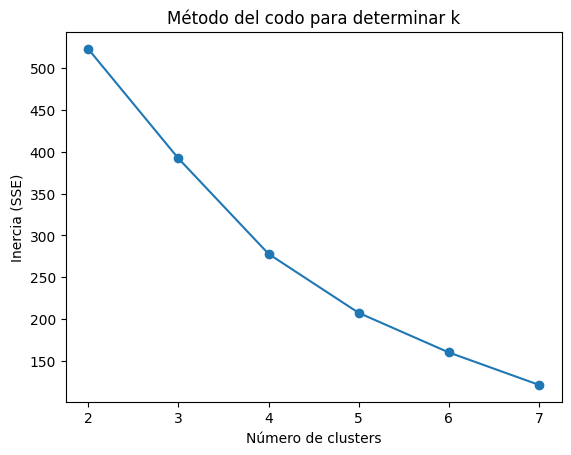

In [87]:

X = df[["Recurso_Fisico","Recurso_Personal","Recurso_Tecnologico","Recurso_Relacional","Recurso_Todos"]]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Elbow para elegir k
inertia = []
for k in range(2, 8):
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_scaled)
    inertia.append(km.inertia_)

plt.plot(range(2,8), inertia, marker='o')
plt.xlabel("Número de clusters")
plt.ylabel("Inercia (SSE)")
plt.title("Método del codo para determinar k")
plt.show()

# Supongamos k=4
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
df["Cluster_Recurso"] = kmeans.fit_predict(X_scaled)


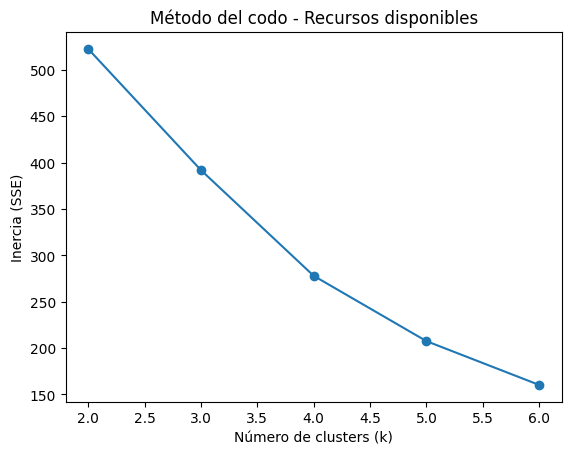


Resumen de clusters:
                             Tipo de cluster  Número de casos
0                    Combinación intermedia               60
1                     Solo recursos humanos               22
2  Recursos humanos, físicos y tecnológicos               17
3    Cuenta con todos los tipos de recursos               16
4                              Sin recursos               15
5                    Humanos y tecnológicos                6
6                Solo recursos relacionales                3


In [88]:

col = "¿Con qué tipo de recursos cuentas (físicos, personal, relacionales o tecnológicos)?"

# --- Funciones de limpieza ---
def sin_acentos(s):
    return "".join(c for c in unicodedata.normalize("NFD", str(s)) if unicodedata.category(c) != "Mn")

def clean_text(s):
    if pd.isna(s): return ""
    t = sin_acentos(str(s).lower())
    t = re.sub(r"[^a-z0-9\s]", " ", t)
    t = re.sub(r"\s+", " ", t)
    return t.strip()

# --- Limpieza y texto base ---
df["Recursos_texto"] = df[col].apply(clean_text)

# --- Clasificación de tipo de recurso (dummies) ---
df["Recurso_Fisico"] = df["Recursos_texto"].str.contains(r"fisic|mueble|sede|espacio|dotacion|oficina|equipo", regex=True).astype(int)
df["Recurso_Personal"] = df["Recursos_texto"].str.contains(r"personal|humano|emplead|funcionari", regex=True).astype(int)
df["Recurso_Tecnologico"] = df["Recursos_texto"].str.contains(r"tecnolog|comput|internet|software|sistema|impresora|digital", regex=True).astype(int)
df["Recurso_Relacional"] = df["Recursos_texto"].str.contains(r"relacion|voluntad|colabor|red|alianz|articul", regex=True).astype(int)
df["Recurso_Ninguno"] = df["Recursos_texto"].str.contains(r"ningun|carec|sin\s+recurs|no\s+tien", regex=True).astype(int)
df["Recurso_Todos"] = df["Recursos_texto"].str.contains(r"todos?|completo|varios|diversos", regex=True).astype(int)

# --- Corrección lógica (si dice "ninguno", apaga los demás) ---
df.loc[df["Recurso_Ninguno"] == 1, ["Recurso_Fisico","Recurso_Personal","Recurso_Tecnologico","Recurso_Relacional","Recurso_Todos"]] = 0

# --- Preparamos matriz de clustering ---
X = df[["Recurso_Fisico","Recurso_Personal","Recurso_Tecnologico","Recurso_Relacional","Recurso_Todos"]]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# --- Método del codo para orientación visual (opcional) ---
inertia = []
for k in range(2, 7):
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_scaled)
    inertia.append(km.inertia_)

plt.plot(range(2,7), inertia, marker='o')
plt.xlabel("Número de clusters (k)")
plt.ylabel("Inercia (SSE)")
plt.title("Método del codo - Recursos disponibles")
plt.show()

# --- Clustering final (ajusta k según gráfico, aquí usamos 4) ---
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
df["Cluster_Recurso"] = kmeans.fit_predict(X_scaled)

# --- Interpretación automática de clusters ---
def interpretar_cluster(row):
    if row["Recurso_Ninguno"] == 1:
        return "Sin recursos"
    elif row["Recurso_Personal"] == 1 and row[["Recurso_Fisico","Recurso_Tecnologico","Recurso_Relacional"]].sum() == 0:
        return "Solo recursos humanos"
    elif row["Recurso_Personal"] == 1 and row["Recurso_Tecnologico"] == 1 and row["Recurso_Fisico"] == 0:
        return "Humanos y tecnológicos"
    elif row["Recurso_Personal"] == 1 and row["Recurso_Fisico"] == 1 and row["Recurso_Tecnologico"] == 1:
        return "Recursos humanos, físicos y tecnológicos"
    elif row["Recurso_Relacional"] == 1 and row[["Recurso_Personal","Recurso_Tecnologico","Recurso_Fisico"]].sum() == 0:
        return "Solo recursos relacionales"
    elif row["Recurso_Todos"] == 1:
        return "Cuenta con todos los tipos de recursos"
    else:
        return "Combinación intermedia"

df["Cluster_Nombre"] = df.apply(interpretar_cluster, axis=1)

# --- Resumen de resultados ---
resumen = df["Cluster_Nombre"].value_counts().reset_index()
resumen.columns = ["Tipo de cluster", "Número de casos"]
print("\nResumen de clusters:\n", resumen)
